In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import ApplicationProperties

[2020-12-18 01:42:47,057][INFO][properties.py:22] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
import torch

from dataset.factory import DatasetFactory
from dataset.nsl_kdd_dataset import NSLKDDDataFrameFactory, NSLKDDDataset
from domain.hyperparameters import Hyperparameters
from domain.metadata import ModelFileMetadata
from logger import logger
from model.factory import ModelFactory
from trainer.base import TrainerBase
from trainer.factory import TrainerFactory

In [3]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

In [4]:
device = "cpu"
data_name = "nsl_kdd"
encoder_model_name = "ae"
occ_model_name = "ae-ocsvm"
n_epoch = 1000

In [5]:
dataset_factory = DatasetFactory.create(data_name=data_name)

[2020-12-18 01:42:48,984][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : train
[2020-12-18 01:42:49,078][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : test
[2020-12-18 01:42:49,224][INFO][nsl_kdd_dataset.py:110] Success to load dataset dataframe : entire
[2020-12-18 01:42:49,588][INFO][nsl_kdd_dataset.py:255] Entire data size : 148517
[2020-12-18 01:42:49,589][INFO][nsl_kdd_dataset.py:256] Normal data size : 77054
[2020-12-18 01:42:49,590][INFO][nsl_kdd_dataset.py:257] Abnormal data size : 7146
[2020-12-18 01:42:49,590][INFO][nsl_kdd_dataset.py:258] Normal test data size : 7146
[2020-12-18 01:42:49,591][INFO][nsl_kdd_dataset.py:259] Training data size : 69908
[2020-12-18 01:42:49,591][INFO][nsl_kdd_dataset.py:260] Test data size : 14292
[2020-12-18 01:42:49,838][INFO][factory.py:77] Success to fit data with scaling
[2020-12-18 01:42:49,916][INFO][factory.py:84] Success to transform data with scaling
[2020-12-18 01:42:49,917][INFO][factory.py:153] Da

In [6]:
dataset_factory.test_dataset[0]

(tensor([-1.1789e-01, -2.6947e-02, -6.3119e-02, -1.0007e-02, -2.4359e-02,
         -7.1477e-03, -9.3671e-02, -2.6299e-02,  6.2874e-01, -1.5420e-02,
         -4.5432e-02, -3.1492e-02, -1.6766e-02, -2.9624e-02, -2.1860e-02,
         -5.4818e-02,  0.0000e+00, -3.7822e-03, -1.0915e-01, -3.7523e-01,
         -4.2118e-01, -1.3530e-01, -1.3296e-01, -2.0555e-01, -2.0817e-01,
          2.0522e-01, -1.9185e-01, -4.6833e-01,  1.0464e+00, -1.1254e+00,
         -1.4558e+00, -1.4429e-01, -4.7636e-01, -3.7897e-01,  4.8766e+00,
         -1.0250e-01, -2.2895e-01, -2.1953e-01, -1.3597e-01,  5.0363e-01,
         -4.7513e-01, -4.9952e-02, -3.0741e-02,  0.0000e+00, -5.7579e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3012e-02, -3.8492e-01,  0.0000e+00, -8.2711e-02,
         -5.6187e-02,  0.0000e+00,  0.0000e+00, -8.8395e-02, -1.1232e-01,
         -2.7264e-01,  0.0000e+00,  0.0000e+00, -1.1757e+00,  0.0000e+00,
         -5.3488e-03,  0.0000e+00,  0.

In [7]:
dataset_factory.train_dataset[0]

(tensor([-0.1179, -0.0290, -0.0612, -0.0100, -0.0244, -0.0071, -0.0937, -0.0263,
          0.6287, -0.0154, -0.0454, -0.0315, -0.0168, -0.0296, -0.0219, -0.0548,
          0.0000, -0.0038, -0.1091, -0.1827, -0.2427, -0.1353, -0.1330, -0.2055,
         -0.2082,  0.2052, -0.1918, -0.4683, -1.1819,  0.6729,  0.5584, -0.3024,
         -0.3200, -0.0762, -0.1452, -0.1025, -0.2290, -0.2195, -0.1360,  0.5036,
         -0.4751, -0.0500, -0.0307,  0.0000, -0.0576,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0230, -0.3849,  0.0000, -0.0827, -0.0562,
          0.0000,  0.0000, -0.0884, -0.1123, -0.2726,  0.0000,  0.0000,  0.8506,
          0.0000, -0.0053,  0.0000,  0.0000,  0.0000,  0.0000, -0.0038,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0491, -0.1890,  0.0000, -0.0505,  0.0000, -0.1550, -0.0100, -0.0038,
          0.0000, -0.0066, -0.3323,  0.0000, -0.0066,  0.0000,  0.0000,  0.0000,
         -0.1117, -0.0076, -

In [8]:
class AE(nn.Module):
    
    def __init__(self, input_size):  # 117
        super(AE, self).__init__()
        self.encoder_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.Tanh()
        )
        self.decoder_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=input_size, bias=True),
            nn.Tanh()
        )
        
        self.he_init_weight()
        
    def forward(self, x):
        z = self.encoder_1(x)
        x_hat = self.decoder_1(z)
        return x_hat, z
    
    def he_init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(module.weight.data)

In [9]:
from copy import deepcopy
import pickle
import time

import torch

from trainer.base import HybridTrainerBase

time.time()


class HybridAETrainer(HybridTrainerBase):

    def __init__(self, encoder_model, encoder_model_file_metadata, occ_trainer, train_loader, val_loader, test_loader, hyperparameters, tqdm_env='script'):
        super(HybridAETrainer, self).__init__(encoder_model, encoder_model_file_metadata, occ_trainer, train_loader, val_loader, test_loader, hyperparameters, tqdm_env)

    def train(self):
        self.model.eval()

        train_result_dict_list = list()
        val_result_dict_list = list()

        best_auc = 0
        best_auc_epoch = 0

        # Set hyperparameters
        n_epoch = self.hyperparameters.n_epoch
        device = self.hyperparameters.device

        for epoch in self.tqdm.tqdm(range(n_epoch)):

            current_model_file_path = self.model_file_metadata.get_save_model_file_path(epoch=epoch)
            self.load_encoder_model(model_file_path=current_model_file_path)

            for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.train_loader):
                data_batch = data_batch.to(device)
                pred_data_batch, latent_data_batch = self.model(data_batch)

                latent_data_batch = latent_data_batch.detach().numpy()

                with torch.no_grad():
                    self.occ_trainer.train(x_train=latent_data_batch)

            train_result_dict = dict()
            val_result_dict = self.validate()

            if best_auc < val_result_dict['auc']:
                best_auc = val_result_dict['auc']
                best_auc_epoch = epoch
                self.best_model = deepcopy(self.occ_trainer.model)

            # Print
            print(
                f"[Epoch {epoch}] "
                f"Val - AUC : {round(val_result_dict['auc'], 7)} | "
                f"Best AUC : {round(best_auc, 7)} (epoch : {best_auc_epoch})"
            )

            # Save Model & Record dictW
            record_dict = dict(
                train_result_dict=train_result_dict,
                val_result_dict=val_result_dict
            )

            self.occ_trainer.save_model(epoch=epoch)
            self.occ_trainer.save_record(record=record_dict, epoch=epoch)

            train_result_dict_list.append(train_result_dict)
            val_result_dict_list.append(val_result_dict)

        # Save last result
        entire_record_dict = dict(
            train_result_dict_list=train_result_dict_list,
            val_result_dict_list=val_result_dict_list
        )

        # Save best model
        with open(self.model_file_metadata.get_best_model_file_path(), "wb") as f:
            pickle.dump(self.best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Save entire_record_dict
        with open(self.model_file_metadata.get_entire_record_file_path(), "wb") as f:
            pickle.dump(entire_record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Load best model
        self.occ_trainer.load_best_model()

        return entire_record_dict

    def validate(self):
        self.model.eval()

        n_batch = 0

        latent_data_list = list()
        abnormal_label_list = list()

        # Set hyperparameters
        device = self.hyperparameters.device

        for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.val_loader):
            data_batch = data_batch.to(device)
            abnormal_label_batch = abnormal_label_batch.to(device)

            with torch.no_grad():
                pred_data_batch, latent_data_batch = self.model(data_batch)

            latent_data_list.append(latent_data_batch)
            abnormal_label_list.append(abnormal_label_batch)

            # total_loss += loss
            n_batch += 1

        latent_data_list = torch.cat(latent_data_list).cpu().numpy()
        abnormal_label_list = torch.cat(abnormal_label_list).cpu().numpy()

        occ_result_dict = self.occ_trainer.validate(x_test=latent_data_list, y_test=abnormal_label_list)

        return dict(auc=occ_result_dict["auc"], latent_data_list=latent_data_list)


In [10]:
ae_model = AE(input_size=117)

In [11]:
ae_model.to(device)

AE(
  (encoder_1): Sequential(
    (0): Linear(in_features=117, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder_1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=117, bias=True)
    (5): Tanh()
  )
)

In [12]:
from sklearn.svm import OneClassSVM

from trainer.occ.ocsvm_trainer import OCSVMTrainer

trainer = HybridAETrainer(
    encoder_model=ae_model,
    encoder_model_file_metadata=ModelFileMetadata(model_name=encoder_model_name),
    occ_trainer=OCSVMTrainer(
        model=OneClassSVM(),
        model_file_metadata=ModelFileMetadata(
            model_name=occ_model_name,
            model_ext=".pkl"
        ),
        hyperparameters=Hyperparameters(
            nu=0.1,
            kernel="rbf",
            gamma=0.1
        )
    ),
    train_loader=dataset_factory.train_dataloader,
    val_loader=dataset_factory.val_dataloader,
    test_loader=dataset_factory.test_dataloader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adadelta,
        criterion=F.mse_loss,
        n_epoch=n_epoch,
        lr=1e-3,
        weight_decay=0,
        device=device
    ),
    tqdm_env="jupyter"
)

[2020-12-18 01:43:00,481][INFO][base.py:40] Model set to 'cpu'


In [13]:
# AE_OCSVM
result_dict = trainer.train()

[2020-12-18 01:43:10,926][DEBUG][base.py:150] Succeed to load model, ae_epoch_0.pt, device: 'cpu'
[2020-12-18 01:43:17,300][DEBUG][base.py:150] Succeed to load model, ae_epoch_1.pt, device: 'cpu'


[Epoch 0] Val - AUC : 0.8432813 | Best AUC : 0.8432813 (epoch : 0)


[2020-12-18 01:43:23,685][DEBUG][base.py:150] Succeed to load model, ae_epoch_2.pt, device: 'cpu'


[Epoch 1] Val - AUC : 0.879301 | Best AUC : 0.879301 (epoch : 1)


[2020-12-18 01:43:30,116][DEBUG][base.py:150] Succeed to load model, ae_epoch_3.pt, device: 'cpu'


[Epoch 2] Val - AUC : 0.8298949 | Best AUC : 0.879301 (epoch : 1)


[2020-12-18 01:43:36,502][DEBUG][base.py:150] Succeed to load model, ae_epoch_4.pt, device: 'cpu'


[Epoch 3] Val - AUC : 0.8431746 | Best AUC : 0.879301 (epoch : 1)


[2020-12-18 01:43:42,867][DEBUG][base.py:150] Succeed to load model, ae_epoch_5.pt, device: 'cpu'


[Epoch 4] Val - AUC : 0.8912987 | Best AUC : 0.8912987 (epoch : 4)


[2020-12-18 01:43:49,181][DEBUG][base.py:150] Succeed to load model, ae_epoch_6.pt, device: 'cpu'


[Epoch 5] Val - AUC : 0.7990311 | Best AUC : 0.8912987 (epoch : 4)


[2020-12-18 01:43:55,512][DEBUG][base.py:150] Succeed to load model, ae_epoch_7.pt, device: 'cpu'


[Epoch 6] Val - AUC : 0.9027476 | Best AUC : 0.9027476 (epoch : 6)


[2020-12-18 01:44:01,870][DEBUG][base.py:150] Succeed to load model, ae_epoch_8.pt, device: 'cpu'


[Epoch 7] Val - AUC : 0.8949631 | Best AUC : 0.9027476 (epoch : 6)


[2020-12-18 01:44:08,211][DEBUG][base.py:150] Succeed to load model, ae_epoch_9.pt, device: 'cpu'


[Epoch 8] Val - AUC : 0.9069214 | Best AUC : 0.9069214 (epoch : 8)


[2020-12-18 01:44:14,583][DEBUG][base.py:150] Succeed to load model, ae_epoch_10.pt, device: 'cpu'


[Epoch 9] Val - AUC : 0.8450965 | Best AUC : 0.9069214 (epoch : 8)


[2020-12-18 01:44:20,923][DEBUG][base.py:150] Succeed to load model, ae_epoch_11.pt, device: 'cpu'


[Epoch 10] Val - AUC : 0.8230418 | Best AUC : 0.9069214 (epoch : 8)


[2020-12-18 01:44:27,268][DEBUG][base.py:150] Succeed to load model, ae_epoch_12.pt, device: 'cpu'


[Epoch 11] Val - AUC : 0.9015453 | Best AUC : 0.9069214 (epoch : 8)


[2020-12-18 01:44:33,600][DEBUG][base.py:150] Succeed to load model, ae_epoch_13.pt, device: 'cpu'


[Epoch 12] Val - AUC : 0.8511418 | Best AUC : 0.9069214 (epoch : 8)


[2020-12-18 01:44:40,001][DEBUG][base.py:150] Succeed to load model, ae_epoch_14.pt, device: 'cpu'


[Epoch 13] Val - AUC : 0.9178458 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:44:46,364][DEBUG][base.py:150] Succeed to load model, ae_epoch_15.pt, device: 'cpu'


[Epoch 14] Val - AUC : 0.8646217 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:44:52,776][DEBUG][base.py:150] Succeed to load model, ae_epoch_16.pt, device: 'cpu'


[Epoch 15] Val - AUC : 0.8461198 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:44:59,154][DEBUG][base.py:150] Succeed to load model, ae_epoch_17.pt, device: 'cpu'


[Epoch 16] Val - AUC : 0.8676945 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:05,505][DEBUG][base.py:150] Succeed to load model, ae_epoch_18.pt, device: 'cpu'


[Epoch 17] Val - AUC : 0.8957375 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:11,818][DEBUG][base.py:150] Succeed to load model, ae_epoch_19.pt, device: 'cpu'


[Epoch 18] Val - AUC : 0.8562396 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:18,154][DEBUG][base.py:150] Succeed to load model, ae_epoch_20.pt, device: 'cpu'


[Epoch 19] Val - AUC : 0.8338063 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:24,488][DEBUG][base.py:150] Succeed to load model, ae_epoch_21.pt, device: 'cpu'


[Epoch 20] Val - AUC : 0.8338792 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:30,815][DEBUG][base.py:150] Succeed to load model, ae_epoch_22.pt, device: 'cpu'


[Epoch 21] Val - AUC : 0.9109709 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:37,150][DEBUG][base.py:150] Succeed to load model, ae_epoch_23.pt, device: 'cpu'


[Epoch 22] Val - AUC : 0.9043711 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:43,448][DEBUG][base.py:150] Succeed to load model, ae_epoch_24.pt, device: 'cpu'


[Epoch 23] Val - AUC : 0.8125384 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:49,753][DEBUG][base.py:150] Succeed to load model, ae_epoch_25.pt, device: 'cpu'


[Epoch 24] Val - AUC : 0.8599665 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:45:56,110][DEBUG][base.py:150] Succeed to load model, ae_epoch_26.pt, device: 'cpu'


[Epoch 25] Val - AUC : 0.7235268 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:46:02,483][DEBUG][base.py:150] Succeed to load model, ae_epoch_27.pt, device: 'cpu'


[Epoch 26] Val - AUC : 0.8763157 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:46:08,795][DEBUG][base.py:150] Succeed to load model, ae_epoch_28.pt, device: 'cpu'


[Epoch 27] Val - AUC : 0.7849944 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:46:15,102][DEBUG][base.py:150] Succeed to load model, ae_epoch_29.pt, device: 'cpu'


[Epoch 28] Val - AUC : 0.8544417 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:46:21,446][DEBUG][base.py:150] Succeed to load model, ae_epoch_30.pt, device: 'cpu'


[Epoch 29] Val - AUC : 0.8299433 | Best AUC : 0.9178458 (epoch : 13)


[2020-12-18 01:46:27,778][DEBUG][base.py:150] Succeed to load model, ae_epoch_31.pt, device: 'cpu'


[Epoch 30] Val - AUC : 0.9202541 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:46:34,106][DEBUG][base.py:150] Succeed to load model, ae_epoch_32.pt, device: 'cpu'


[Epoch 31] Val - AUC : 0.6876649 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:46:40,445][DEBUG][base.py:150] Succeed to load model, ae_epoch_33.pt, device: 'cpu'


[Epoch 32] Val - AUC : 0.8169422 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:46:46,834][DEBUG][base.py:150] Succeed to load model, ae_epoch_34.pt, device: 'cpu'


[Epoch 33] Val - AUC : 0.8589236 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:46:53,362][DEBUG][base.py:150] Succeed to load model, ae_epoch_35.pt, device: 'cpu'


[Epoch 34] Val - AUC : 0.7967325 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:46:59,717][DEBUG][base.py:150] Succeed to load model, ae_epoch_36.pt, device: 'cpu'


[Epoch 35] Val - AUC : 0.8721847 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:06,044][DEBUG][base.py:150] Succeed to load model, ae_epoch_37.pt, device: 'cpu'


[Epoch 36] Val - AUC : 0.8868089 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:12,363][DEBUG][base.py:150] Succeed to load model, ae_epoch_38.pt, device: 'cpu'


[Epoch 37] Val - AUC : 0.8991552 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:18,717][DEBUG][base.py:150] Succeed to load model, ae_epoch_39.pt, device: 'cpu'


[Epoch 38] Val - AUC : 0.9177884 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:25,078][DEBUG][base.py:150] Succeed to load model, ae_epoch_40.pt, device: 'cpu'


[Epoch 39] Val - AUC : 0.8841765 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:31,391][DEBUG][base.py:150] Succeed to load model, ae_epoch_41.pt, device: 'cpu'


[Epoch 40] Val - AUC : 0.8805009 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:37,747][DEBUG][base.py:150] Succeed to load model, ae_epoch_42.pt, device: 'cpu'


[Epoch 41] Val - AUC : 0.9046136 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:44,067][DEBUG][base.py:150] Succeed to load model, ae_epoch_43.pt, device: 'cpu'


[Epoch 42] Val - AUC : 0.8079106 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:50,409][DEBUG][base.py:150] Succeed to load model, ae_epoch_44.pt, device: 'cpu'


[Epoch 43] Val - AUC : 0.8270421 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:47:56,719][DEBUG][base.py:150] Succeed to load model, ae_epoch_45.pt, device: 'cpu'


[Epoch 44] Val - AUC : 0.9053485 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:03,042][DEBUG][base.py:150] Succeed to load model, ae_epoch_46.pt, device: 'cpu'


[Epoch 45] Val - AUC : 0.8988195 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:09,332][DEBUG][base.py:150] Succeed to load model, ae_epoch_47.pt, device: 'cpu'


[Epoch 46] Val - AUC : 0.8634283 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:15,630][DEBUG][base.py:150] Succeed to load model, ae_epoch_48.pt, device: 'cpu'


[Epoch 47] Val - AUC : 0.853532 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:21,956][DEBUG][base.py:150] Succeed to load model, ae_epoch_49.pt, device: 'cpu'


[Epoch 48] Val - AUC : 0.8441038 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:28,242][DEBUG][base.py:150] Succeed to load model, ae_epoch_50.pt, device: 'cpu'


[Epoch 49] Val - AUC : 0.9185315 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:34,578][DEBUG][base.py:150] Succeed to load model, ae_epoch_51.pt, device: 'cpu'


[Epoch 50] Val - AUC : 0.9061048 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:40,913][DEBUG][base.py:150] Succeed to load model, ae_epoch_52.pt, device: 'cpu'


[Epoch 51] Val - AUC : 0.8780354 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:47,198][DEBUG][base.py:150] Succeed to load model, ae_epoch_53.pt, device: 'cpu'


[Epoch 52] Val - AUC : 0.721705 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:53,486][DEBUG][base.py:150] Succeed to load model, ae_epoch_54.pt, device: 'cpu'


[Epoch 53] Val - AUC : 0.9033759 | Best AUC : 0.9202541 (epoch : 30)


[2020-12-18 01:48:59,807][DEBUG][base.py:150] Succeed to load model, ae_epoch_55.pt, device: 'cpu'


[Epoch 54] Val - AUC : 0.9281781 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:06,100][DEBUG][base.py:150] Succeed to load model, ae_epoch_56.pt, device: 'cpu'


[Epoch 55] Val - AUC : 0.7578122 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:12,416][DEBUG][base.py:150] Succeed to load model, ae_epoch_57.pt, device: 'cpu'


[Epoch 56] Val - AUC : 0.8133988 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:18,710][DEBUG][base.py:150] Succeed to load model, ae_epoch_58.pt, device: 'cpu'


[Epoch 57] Val - AUC : 0.850094 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:25,008][DEBUG][base.py:150] Succeed to load model, ae_epoch_59.pt, device: 'cpu'


[Epoch 58] Val - AUC : 0.8952229 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:31,304][DEBUG][base.py:150] Succeed to load model, ae_epoch_60.pt, device: 'cpu'


[Epoch 59] Val - AUC : 0.9063951 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:37,622][DEBUG][base.py:150] Succeed to load model, ae_epoch_61.pt, device: 'cpu'


[Epoch 60] Val - AUC : 0.7921895 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:44,074][DEBUG][base.py:150] Succeed to load model, ae_epoch_62.pt, device: 'cpu'


[Epoch 61] Val - AUC : 0.7880864 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:50,476][DEBUG][base.py:150] Succeed to load model, ae_epoch_63.pt, device: 'cpu'


[Epoch 62] Val - AUC : 0.8842794 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:49:56,981][DEBUG][base.py:150] Succeed to load model, ae_epoch_64.pt, device: 'cpu'


[Epoch 63] Val - AUC : 0.9271534 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:03,333][DEBUG][base.py:150] Succeed to load model, ae_epoch_65.pt, device: 'cpu'


[Epoch 64] Val - AUC : 0.7869412 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:09,616][DEBUG][base.py:150] Succeed to load model, ae_epoch_66.pt, device: 'cpu'


[Epoch 65] Val - AUC : 0.8099469 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:15,903][DEBUG][base.py:150] Succeed to load model, ae_epoch_67.pt, device: 'cpu'


[Epoch 66] Val - AUC : 0.8970608 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:22,204][DEBUG][base.py:150] Succeed to load model, ae_epoch_68.pt, device: 'cpu'


[Epoch 67] Val - AUC : 0.9170729 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:28,486][DEBUG][base.py:150] Succeed to load model, ae_epoch_69.pt, device: 'cpu'


[Epoch 68] Val - AUC : 0.8637435 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:34,770][DEBUG][base.py:150] Succeed to load model, ae_epoch_70.pt, device: 'cpu'


[Epoch 69] Val - AUC : 0.9224119 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:41,062][DEBUG][base.py:150] Succeed to load model, ae_epoch_71.pt, device: 'cpu'


[Epoch 70] Val - AUC : 0.913447 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:47,357][DEBUG][base.py:150] Succeed to load model, ae_epoch_72.pt, device: 'cpu'


[Epoch 71] Val - AUC : 0.7413946 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:50:53,750][DEBUG][base.py:150] Succeed to load model, ae_epoch_73.pt, device: 'cpu'


[Epoch 72] Val - AUC : 0.874353 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:00,202][DEBUG][base.py:150] Succeed to load model, ae_epoch_74.pt, device: 'cpu'


[Epoch 73] Val - AUC : 0.8786892 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:06,560][DEBUG][base.py:150] Succeed to load model, ae_epoch_75.pt, device: 'cpu'


[Epoch 74] Val - AUC : 0.6769959 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:12,959][DEBUG][base.py:150] Succeed to load model, ae_epoch_76.pt, device: 'cpu'


[Epoch 75] Val - AUC : 0.8730558 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:19,321][DEBUG][base.py:150] Succeed to load model, ae_epoch_77.pt, device: 'cpu'


[Epoch 76] Val - AUC : 0.9117354 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:25,756][DEBUG][base.py:150] Succeed to load model, ae_epoch_78.pt, device: 'cpu'


[Epoch 77] Val - AUC : 0.7252152 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:32,120][DEBUG][base.py:150] Succeed to load model, ae_epoch_79.pt, device: 'cpu'


[Epoch 78] Val - AUC : 0.8794348 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:38,483][DEBUG][base.py:150] Succeed to load model, ae_epoch_80.pt, device: 'cpu'


[Epoch 79] Val - AUC : 0.9191086 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:44,877][DEBUG][base.py:150] Succeed to load model, ae_epoch_81.pt, device: 'cpu'


[Epoch 80] Val - AUC : 0.8585906 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:51,272][DEBUG][base.py:150] Succeed to load model, ae_epoch_82.pt, device: 'cpu'


[Epoch 81] Val - AUC : 0.8821068 | Best AUC : 0.9281781 (epoch : 54)


[2020-12-18 01:51:57,615][DEBUG][base.py:150] Succeed to load model, ae_epoch_83.pt, device: 'cpu'


[Epoch 82] Val - AUC : 0.9310041 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:03,997][DEBUG][base.py:150] Succeed to load model, ae_epoch_84.pt, device: 'cpu'


[Epoch 83] Val - AUC : 0.9122626 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:10,417][DEBUG][base.py:150] Succeed to load model, ae_epoch_85.pt, device: 'cpu'


[Epoch 84] Val - AUC : 0.8697756 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:16,786][DEBUG][base.py:150] Succeed to load model, ae_epoch_86.pt, device: 'cpu'


[Epoch 85] Val - AUC : 0.8498323 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:23,247][DEBUG][base.py:150] Succeed to load model, ae_epoch_87.pt, device: 'cpu'


[Epoch 86] Val - AUC : 0.8875391 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:29,602][DEBUG][base.py:150] Succeed to load model, ae_epoch_88.pt, device: 'cpu'


[Epoch 87] Val - AUC : 0.9196775 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:35,975][DEBUG][base.py:150] Succeed to load model, ae_epoch_89.pt, device: 'cpu'


[Epoch 88] Val - AUC : 0.8396241 | Best AUC : 0.9310041 (epoch : 82)


[2020-12-18 01:52:42,423][DEBUG][base.py:150] Succeed to load model, ae_epoch_90.pt, device: 'cpu'


[Epoch 89] Val - AUC : 0.935937 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:52:48,792][DEBUG][base.py:150] Succeed to load model, ae_epoch_91.pt, device: 'cpu'


[Epoch 90] Val - AUC : 0.886151 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:52:55,275][DEBUG][base.py:150] Succeed to load model, ae_epoch_92.pt, device: 'cpu'


[Epoch 91] Val - AUC : 0.8752395 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:01,691][DEBUG][base.py:150] Succeed to load model, ae_epoch_93.pt, device: 'cpu'


[Epoch 92] Val - AUC : 0.8874085 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:08,045][DEBUG][base.py:150] Succeed to load model, ae_epoch_94.pt, device: 'cpu'


[Epoch 93] Val - AUC : 0.888289 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:14,434][DEBUG][base.py:150] Succeed to load model, ae_epoch_95.pt, device: 'cpu'


[Epoch 94] Val - AUC : 0.8766197 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:20,742][DEBUG][base.py:150] Succeed to load model, ae_epoch_96.pt, device: 'cpu'


[Epoch 95] Val - AUC : 0.8980301 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:27,047][DEBUG][base.py:150] Succeed to load model, ae_epoch_97.pt, device: 'cpu'


[Epoch 96] Val - AUC : 0.9289449 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:33,348][DEBUG][base.py:150] Succeed to load model, ae_epoch_98.pt, device: 'cpu'


[Epoch 97] Val - AUC : 0.8963308 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:39,674][DEBUG][base.py:150] Succeed to load model, ae_epoch_99.pt, device: 'cpu'


[Epoch 98] Val - AUC : 0.9150503 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:45,982][DEBUG][base.py:150] Succeed to load model, ae_epoch_100.pt, device: 'cpu'


[Epoch 99] Val - AUC : 0.8892348 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:52,395][DEBUG][base.py:150] Succeed to load model, ae_epoch_101.pt, device: 'cpu'


[Epoch 100] Val - AUC : 0.8334365 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:53:58,778][DEBUG][base.py:150] Succeed to load model, ae_epoch_102.pt, device: 'cpu'


[Epoch 101] Val - AUC : 0.8837375 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:05,183][DEBUG][base.py:150] Succeed to load model, ae_epoch_103.pt, device: 'cpu'


[Epoch 102] Val - AUC : 0.8662322 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:11,648][DEBUG][base.py:150] Succeed to load model, ae_epoch_104.pt, device: 'cpu'


[Epoch 103] Val - AUC : 0.9292769 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:17,985][DEBUG][base.py:150] Succeed to load model, ae_epoch_105.pt, device: 'cpu'


[Epoch 104] Val - AUC : 0.9292146 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:24,373][DEBUG][base.py:150] Succeed to load model, ae_epoch_106.pt, device: 'cpu'


[Epoch 105] Val - AUC : 0.8229967 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:30,695][DEBUG][base.py:150] Succeed to load model, ae_epoch_107.pt, device: 'cpu'


[Epoch 106] Val - AUC : 0.905066 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:37,000][DEBUG][base.py:150] Succeed to load model, ae_epoch_108.pt, device: 'cpu'


[Epoch 107] Val - AUC : 0.9039684 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:43,321][DEBUG][base.py:150] Succeed to load model, ae_epoch_109.pt, device: 'cpu'


[Epoch 108] Val - AUC : 0.8157922 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:49,611][DEBUG][base.py:150] Succeed to load model, ae_epoch_110.pt, device: 'cpu'


[Epoch 109] Val - AUC : 0.8664617 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:54:55,939][DEBUG][base.py:150] Succeed to load model, ae_epoch_111.pt, device: 'cpu'


[Epoch 110] Val - AUC : 0.8766681 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:02,236][DEBUG][base.py:150] Succeed to load model, ae_epoch_112.pt, device: 'cpu'


[Epoch 111] Val - AUC : 0.8850196 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:08,519][DEBUG][base.py:150] Succeed to load model, ae_epoch_113.pt, device: 'cpu'


[Epoch 112] Val - AUC : 0.8539272 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:14,901][DEBUG][base.py:150] Succeed to load model, ae_epoch_114.pt, device: 'cpu'


[Epoch 113] Val - AUC : 0.7413805 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:21,188][DEBUG][base.py:150] Succeed to load model, ae_epoch_115.pt, device: 'cpu'


[Epoch 114] Val - AUC : 0.8453396 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:27,495][DEBUG][base.py:150] Succeed to load model, ae_epoch_116.pt, device: 'cpu'


[Epoch 115] Val - AUC : 0.9279362 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:33,811][DEBUG][base.py:150] Succeed to load model, ae_epoch_117.pt, device: 'cpu'


[Epoch 116] Val - AUC : 0.7785827 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:40,139][DEBUG][base.py:150] Succeed to load model, ae_epoch_118.pt, device: 'cpu'


[Epoch 117] Val - AUC : 0.852978 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:46,434][DEBUG][base.py:150] Succeed to load model, ae_epoch_119.pt, device: 'cpu'


[Epoch 118] Val - AUC : 0.8794019 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:52,725][DEBUG][base.py:150] Succeed to load model, ae_epoch_120.pt, device: 'cpu'


[Epoch 119] Val - AUC : 0.9293465 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:55:59,098][DEBUG][base.py:150] Succeed to load model, ae_epoch_121.pt, device: 'cpu'


[Epoch 120] Val - AUC : 0.8985016 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:05,492][DEBUG][base.py:150] Succeed to load model, ae_epoch_122.pt, device: 'cpu'


[Epoch 121] Val - AUC : 0.9088616 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:11,815][DEBUG][base.py:150] Succeed to load model, ae_epoch_123.pt, device: 'cpu'


[Epoch 122] Val - AUC : 0.8940107 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:18,118][DEBUG][base.py:150] Succeed to load model, ae_epoch_124.pt, device: 'cpu'


[Epoch 123] Val - AUC : 0.7517112 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:24,469][DEBUG][base.py:150] Succeed to load model, ae_epoch_125.pt, device: 'cpu'


[Epoch 124] Val - AUC : 0.91561 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:30,784][DEBUG][base.py:150] Succeed to load model, ae_epoch_126.pt, device: 'cpu'


[Epoch 125] Val - AUC : 0.8936837 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:37,262][DEBUG][base.py:150] Succeed to load model, ae_epoch_127.pt, device: 'cpu'


[Epoch 126] Val - AUC : 0.8898346 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:43,636][DEBUG][base.py:150] Succeed to load model, ae_epoch_128.pt, device: 'cpu'


[Epoch 127] Val - AUC : 0.852457 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:50,089][DEBUG][base.py:150] Succeed to load model, ae_epoch_129.pt, device: 'cpu'


[Epoch 128] Val - AUC : 0.9222212 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:56:56,396][DEBUG][base.py:150] Succeed to load model, ae_epoch_130.pt, device: 'cpu'


[Epoch 129] Val - AUC : 0.8289462 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:02,713][DEBUG][base.py:150] Succeed to load model, ae_epoch_131.pt, device: 'cpu'


[Epoch 130] Val - AUC : 0.8607247 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:09,052][DEBUG][base.py:150] Succeed to load model, ae_epoch_132.pt, device: 'cpu'


[Epoch 131] Val - AUC : 0.8523445 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:15,361][DEBUG][base.py:150] Succeed to load model, ae_epoch_133.pt, device: 'cpu'


[Epoch 132] Val - AUC : 0.9031936 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:21,652][DEBUG][base.py:150] Succeed to load model, ae_epoch_134.pt, device: 'cpu'


[Epoch 133] Val - AUC : 0.8795193 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:27,946][DEBUG][base.py:150] Succeed to load model, ae_epoch_135.pt, device: 'cpu'


[Epoch 134] Val - AUC : 0.8754634 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:34,282][DEBUG][base.py:150] Succeed to load model, ae_epoch_136.pt, device: 'cpu'


[Epoch 135] Val - AUC : 0.8692271 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:40,652][DEBUG][base.py:150] Succeed to load model, ae_epoch_137.pt, device: 'cpu'


[Epoch 136] Val - AUC : 0.9005972 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:46,964][DEBUG][base.py:150] Succeed to load model, ae_epoch_138.pt, device: 'cpu'


[Epoch 137] Val - AUC : 0.8913893 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:53,498][DEBUG][base.py:150] Succeed to load model, ae_epoch_139.pt, device: 'cpu'


[Epoch 138] Val - AUC : 0.8840724 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:57:59,943][DEBUG][base.py:150] Succeed to load model, ae_epoch_140.pt, device: 'cpu'


[Epoch 139] Val - AUC : 0.8128664 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:06,251][DEBUG][base.py:150] Succeed to load model, ae_epoch_141.pt, device: 'cpu'


[Epoch 140] Val - AUC : 0.8621916 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:12,597][DEBUG][base.py:150] Succeed to load model, ae_epoch_142.pt, device: 'cpu'


[Epoch 141] Val - AUC : 0.868813 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:18,900][DEBUG][base.py:150] Succeed to load model, ae_epoch_143.pt, device: 'cpu'


[Epoch 142] Val - AUC : 0.8263648 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:25,217][DEBUG][base.py:150] Succeed to load model, ae_epoch_144.pt, device: 'cpu'


[Epoch 143] Val - AUC : 0.9331093 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:31,518][DEBUG][base.py:150] Succeed to load model, ae_epoch_145.pt, device: 'cpu'


[Epoch 144] Val - AUC : 0.9039541 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:37,840][DEBUG][base.py:150] Succeed to load model, ae_epoch_146.pt, device: 'cpu'


[Epoch 145] Val - AUC : 0.8082234 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:44,145][DEBUG][base.py:150] Succeed to load model, ae_epoch_147.pt, device: 'cpu'


[Epoch 146] Val - AUC : 0.8946914 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:50,436][DEBUG][base.py:150] Succeed to load model, ae_epoch_148.pt, device: 'cpu'


[Epoch 147] Val - AUC : 0.889481 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:58:56,718][DEBUG][base.py:150] Succeed to load model, ae_epoch_149.pt, device: 'cpu'


[Epoch 148] Val - AUC : 0.920311 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:03,036][DEBUG][base.py:150] Succeed to load model, ae_epoch_150.pt, device: 'cpu'


[Epoch 149] Val - AUC : 0.8664964 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:09,378][DEBUG][base.py:150] Succeed to load model, ae_epoch_151.pt, device: 'cpu'


[Epoch 150] Val - AUC : 0.9231235 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:15,684][DEBUG][base.py:150] Succeed to load model, ae_epoch_152.pt, device: 'cpu'


[Epoch 151] Val - AUC : 0.8673777 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:21,997][DEBUG][base.py:150] Succeed to load model, ae_epoch_153.pt, device: 'cpu'


[Epoch 152] Val - AUC : 0.9245222 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:28,306][DEBUG][base.py:150] Succeed to load model, ae_epoch_154.pt, device: 'cpu'


[Epoch 153] Val - AUC : 0.8105263 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:34,613][DEBUG][base.py:150] Succeed to load model, ae_epoch_155.pt, device: 'cpu'


[Epoch 154] Val - AUC : 0.8812263 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:40,907][DEBUG][base.py:150] Succeed to load model, ae_epoch_156.pt, device: 'cpu'


[Epoch 155] Val - AUC : 0.8802701 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:47,192][DEBUG][base.py:150] Succeed to load model, ae_epoch_157.pt, device: 'cpu'


[Epoch 156] Val - AUC : 0.8852077 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:53,504][DEBUG][base.py:150] Succeed to load model, ae_epoch_158.pt, device: 'cpu'


[Epoch 157] Val - AUC : 0.8835503 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 01:59:59,802][DEBUG][base.py:150] Succeed to load model, ae_epoch_159.pt, device: 'cpu'


[Epoch 158] Val - AUC : 0.8850648 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:06,092][DEBUG][base.py:150] Succeed to load model, ae_epoch_160.pt, device: 'cpu'


[Epoch 159] Val - AUC : 0.9082282 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:12,401][DEBUG][base.py:150] Succeed to load model, ae_epoch_161.pt, device: 'cpu'


[Epoch 160] Val - AUC : 0.8974569 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:18,705][DEBUG][base.py:150] Succeed to load model, ae_epoch_162.pt, device: 'cpu'


[Epoch 161] Val - AUC : 0.9020262 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:25,016][DEBUG][base.py:150] Succeed to load model, ae_epoch_163.pt, device: 'cpu'


[Epoch 162] Val - AUC : 0.8935645 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:31,329][DEBUG][base.py:150] Succeed to load model, ae_epoch_164.pt, device: 'cpu'


[Epoch 163] Val - AUC : 0.862185 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:37,696][DEBUG][base.py:150] Succeed to load model, ae_epoch_165.pt, device: 'cpu'


[Epoch 164] Val - AUC : 0.9153324 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:44,045][DEBUG][base.py:150] Succeed to load model, ae_epoch_166.pt, device: 'cpu'


[Epoch 165] Val - AUC : 0.8748765 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:50,348][DEBUG][base.py:150] Succeed to load model, ae_epoch_167.pt, device: 'cpu'


[Epoch 166] Val - AUC : 0.9126396 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:00:56,631][DEBUG][base.py:150] Succeed to load model, ae_epoch_168.pt, device: 'cpu'


[Epoch 167] Val - AUC : 0.8990019 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:02,966][DEBUG][base.py:150] Succeed to load model, ae_epoch_169.pt, device: 'cpu'


[Epoch 168] Val - AUC : 0.8969958 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:09,357][DEBUG][base.py:150] Succeed to load model, ae_epoch_170.pt, device: 'cpu'


[Epoch 169] Val - AUC : 0.8513673 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:15,829][DEBUG][base.py:150] Succeed to load model, ae_epoch_171.pt, device: 'cpu'


[Epoch 170] Val - AUC : 0.8772072 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:22,388][DEBUG][base.py:150] Succeed to load model, ae_epoch_172.pt, device: 'cpu'


[Epoch 171] Val - AUC : 0.852988 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:28,854][DEBUG][base.py:150] Succeed to load model, ae_epoch_173.pt, device: 'cpu'


[Epoch 172] Val - AUC : 0.9026066 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:35,353][DEBUG][base.py:150] Succeed to load model, ae_epoch_174.pt, device: 'cpu'


[Epoch 173] Val - AUC : 0.7550589 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:41,887][DEBUG][base.py:150] Succeed to load model, ae_epoch_175.pt, device: 'cpu'


[Epoch 174] Val - AUC : 0.8195872 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:48,348][DEBUG][base.py:150] Succeed to load model, ae_epoch_176.pt, device: 'cpu'


[Epoch 175] Val - AUC : 0.8837776 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:01:54,934][DEBUG][base.py:150] Succeed to load model, ae_epoch_177.pt, device: 'cpu'


[Epoch 176] Val - AUC : 0.8940678 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:01,465][DEBUG][base.py:150] Succeed to load model, ae_epoch_178.pt, device: 'cpu'


[Epoch 177] Val - AUC : 0.9025556 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:07,870][DEBUG][base.py:150] Succeed to load model, ae_epoch_179.pt, device: 'cpu'


[Epoch 178] Val - AUC : 0.7830586 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:14,330][DEBUG][base.py:150] Succeed to load model, ae_epoch_180.pt, device: 'cpu'


[Epoch 179] Val - AUC : 0.9016257 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:20,918][DEBUG][base.py:150] Succeed to load model, ae_epoch_181.pt, device: 'cpu'


[Epoch 180] Val - AUC : 0.9074689 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:27,390][DEBUG][base.py:150] Succeed to load model, ae_epoch_182.pt, device: 'cpu'


[Epoch 181] Val - AUC : 0.8720006 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:33,874][DEBUG][base.py:150] Succeed to load model, ae_epoch_183.pt, device: 'cpu'


[Epoch 182] Val - AUC : 0.8190063 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:40,337][DEBUG][base.py:150] Succeed to load model, ae_epoch_184.pt, device: 'cpu'


[Epoch 183] Val - AUC : 0.8758131 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:46,710][DEBUG][base.py:150] Succeed to load model, ae_epoch_185.pt, device: 'cpu'


[Epoch 184] Val - AUC : 0.7264665 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:53,110][DEBUG][base.py:150] Succeed to load model, ae_epoch_186.pt, device: 'cpu'


[Epoch 185] Val - AUC : 0.9146404 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:02:59,513][DEBUG][base.py:150] Succeed to load model, ae_epoch_187.pt, device: 'cpu'


[Epoch 186] Val - AUC : 0.8783133 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:05,937][DEBUG][base.py:150] Succeed to load model, ae_epoch_188.pt, device: 'cpu'


[Epoch 187] Val - AUC : 0.8813923 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:12,413][DEBUG][base.py:150] Succeed to load model, ae_epoch_189.pt, device: 'cpu'


[Epoch 188] Val - AUC : 0.8747162 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:18,778][DEBUG][base.py:150] Succeed to load model, ae_epoch_190.pt, device: 'cpu'


[Epoch 189] Val - AUC : 0.8843684 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:25,114][DEBUG][base.py:150] Succeed to load model, ae_epoch_191.pt, device: 'cpu'


[Epoch 190] Val - AUC : 0.890436 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:31,504][DEBUG][base.py:150] Succeed to load model, ae_epoch_192.pt, device: 'cpu'


[Epoch 191] Val - AUC : 0.906835 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:37,870][DEBUG][base.py:150] Succeed to load model, ae_epoch_193.pt, device: 'cpu'


[Epoch 192] Val - AUC : 0.8654228 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:44,320][DEBUG][base.py:150] Succeed to load model, ae_epoch_194.pt, device: 'cpu'


[Epoch 193] Val - AUC : 0.8164951 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:50,740][DEBUG][base.py:150] Succeed to load model, ae_epoch_195.pt, device: 'cpu'


[Epoch 194] Val - AUC : 0.8828064 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:03:57,109][DEBUG][base.py:150] Succeed to load model, ae_epoch_196.pt, device: 'cpu'


[Epoch 195] Val - AUC : 0.8704269 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:03,534][DEBUG][base.py:150] Succeed to load model, ae_epoch_197.pt, device: 'cpu'


[Epoch 196] Val - AUC : 0.9013205 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:10,012][DEBUG][base.py:150] Succeed to load model, ae_epoch_198.pt, device: 'cpu'


[Epoch 197] Val - AUC : 0.8243049 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:16,367][DEBUG][base.py:150] Succeed to load model, ae_epoch_199.pt, device: 'cpu'


[Epoch 198] Val - AUC : 0.9172265 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:22,798][DEBUG][base.py:150] Succeed to load model, ae_epoch_200.pt, device: 'cpu'


[Epoch 199] Val - AUC : 0.9166305 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:29,214][DEBUG][base.py:150] Succeed to load model, ae_epoch_201.pt, device: 'cpu'


[Epoch 200] Val - AUC : 0.9103356 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:35,605][DEBUG][base.py:150] Succeed to load model, ae_epoch_202.pt, device: 'cpu'


[Epoch 201] Val - AUC : 0.9038285 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:41,990][DEBUG][base.py:150] Succeed to load model, ae_epoch_203.pt, device: 'cpu'


[Epoch 202] Val - AUC : 0.829963 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:48,379][DEBUG][base.py:150] Succeed to load model, ae_epoch_204.pt, device: 'cpu'


[Epoch 203] Val - AUC : 0.884694 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:04:54,757][DEBUG][base.py:150] Succeed to load model, ae_epoch_205.pt, device: 'cpu'


[Epoch 204] Val - AUC : 0.8979599 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:01,134][DEBUG][base.py:150] Succeed to load model, ae_epoch_206.pt, device: 'cpu'


[Epoch 205] Val - AUC : 0.8589854 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:07,490][DEBUG][base.py:150] Succeed to load model, ae_epoch_207.pt, device: 'cpu'


[Epoch 206] Val - AUC : 0.857582 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:13,925][DEBUG][base.py:150] Succeed to load model, ae_epoch_208.pt, device: 'cpu'


[Epoch 207] Val - AUC : 0.9134398 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:20,259][DEBUG][base.py:150] Succeed to load model, ae_epoch_209.pt, device: 'cpu'


[Epoch 208] Val - AUC : 0.8803465 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:26,751][DEBUG][base.py:150] Succeed to load model, ae_epoch_210.pt, device: 'cpu'


[Epoch 209] Val - AUC : 0.9118516 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:33,148][DEBUG][base.py:150] Succeed to load model, ae_epoch_211.pt, device: 'cpu'


[Epoch 210] Val - AUC : 0.902965 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:39,561][DEBUG][base.py:150] Succeed to load model, ae_epoch_212.pt, device: 'cpu'


[Epoch 211] Val - AUC : 0.8138562 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:45,930][DEBUG][base.py:150] Succeed to load model, ae_epoch_213.pt, device: 'cpu'


[Epoch 212] Val - AUC : 0.8847924 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:52,321][DEBUG][base.py:150] Succeed to load model, ae_epoch_214.pt, device: 'cpu'


[Epoch 213] Val - AUC : 0.8131223 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:05:58,834][DEBUG][base.py:150] Succeed to load model, ae_epoch_215.pt, device: 'cpu'


[Epoch 214] Val - AUC : 0.898471 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:05,163][DEBUG][base.py:150] Succeed to load model, ae_epoch_216.pt, device: 'cpu'


[Epoch 215] Val - AUC : 0.8566278 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:11,566][DEBUG][base.py:150] Succeed to load model, ae_epoch_217.pt, device: 'cpu'


[Epoch 216] Val - AUC : 0.8010966 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:17,922][DEBUG][base.py:150] Succeed to load model, ae_epoch_218.pt, device: 'cpu'


[Epoch 217] Val - AUC : 0.8394552 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:24,405][DEBUG][base.py:150] Succeed to load model, ae_epoch_219.pt, device: 'cpu'


[Epoch 218] Val - AUC : 0.8342664 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:30,731][DEBUG][base.py:150] Succeed to load model, ae_epoch_220.pt, device: 'cpu'


[Epoch 219] Val - AUC : 0.6816294 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:37,111][DEBUG][base.py:150] Succeed to load model, ae_epoch_221.pt, device: 'cpu'


[Epoch 220] Val - AUC : 0.7953736 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:43,567][DEBUG][base.py:150] Succeed to load model, ae_epoch_222.pt, device: 'cpu'


[Epoch 221] Val - AUC : 0.9103097 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:49,912][DEBUG][base.py:150] Succeed to load model, ae_epoch_223.pt, device: 'cpu'


[Epoch 222] Val - AUC : 0.8980378 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:06:56,446][DEBUG][base.py:150] Succeed to load model, ae_epoch_224.pt, device: 'cpu'


[Epoch 223] Val - AUC : 0.8798491 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:02,870][DEBUG][base.py:150] Succeed to load model, ae_epoch_225.pt, device: 'cpu'


[Epoch 224] Val - AUC : 0.9163579 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:09,228][DEBUG][base.py:150] Succeed to load model, ae_epoch_226.pt, device: 'cpu'


[Epoch 225] Val - AUC : 0.7399549 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:15,719][DEBUG][base.py:150] Succeed to load model, ae_epoch_227.pt, device: 'cpu'


[Epoch 226] Val - AUC : 0.8882496 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:22,082][DEBUG][base.py:150] Succeed to load model, ae_epoch_228.pt, device: 'cpu'


[Epoch 227] Val - AUC : 0.8796084 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:28,446][DEBUG][base.py:150] Succeed to load model, ae_epoch_229.pt, device: 'cpu'


[Epoch 228] Val - AUC : 0.882097 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:34,833][DEBUG][base.py:150] Succeed to load model, ae_epoch_230.pt, device: 'cpu'


[Epoch 229] Val - AUC : 0.8679542 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:41,394][DEBUG][base.py:150] Succeed to load model, ae_epoch_231.pt, device: 'cpu'


[Epoch 230] Val - AUC : 0.8620728 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:47,833][DEBUG][base.py:150] Succeed to load model, ae_epoch_232.pt, device: 'cpu'


[Epoch 231] Val - AUC : 0.9068565 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:07:54,342][DEBUG][base.py:150] Succeed to load model, ae_epoch_233.pt, device: 'cpu'


[Epoch 232] Val - AUC : 0.8671921 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:00,702][DEBUG][base.py:150] Succeed to load model, ae_epoch_234.pt, device: 'cpu'


[Epoch 233] Val - AUC : 0.8222344 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:07,093][DEBUG][base.py:150] Succeed to load model, ae_epoch_235.pt, device: 'cpu'


[Epoch 234] Val - AUC : 0.8702772 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:13,475][DEBUG][base.py:150] Succeed to load model, ae_epoch_236.pt, device: 'cpu'


[Epoch 235] Val - AUC : 0.8687972 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:19,849][DEBUG][base.py:150] Succeed to load model, ae_epoch_237.pt, device: 'cpu'


[Epoch 236] Val - AUC : 0.8517677 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:26,272][DEBUG][base.py:150] Succeed to load model, ae_epoch_238.pt, device: 'cpu'


[Epoch 237] Val - AUC : 0.7256485 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:32,634][DEBUG][base.py:150] Succeed to load model, ae_epoch_239.pt, device: 'cpu'


[Epoch 238] Val - AUC : 0.9089583 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:39,030][DEBUG][base.py:150] Succeed to load model, ae_epoch_240.pt, device: 'cpu'


[Epoch 239] Val - AUC : 0.8513392 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:45,401][DEBUG][base.py:150] Succeed to load model, ae_epoch_241.pt, device: 'cpu'


[Epoch 240] Val - AUC : 0.8413448 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:51,800][DEBUG][base.py:150] Succeed to load model, ae_epoch_242.pt, device: 'cpu'


[Epoch 241] Val - AUC : 0.8746532 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:08:58,144][DEBUG][base.py:150] Succeed to load model, ae_epoch_243.pt, device: 'cpu'


[Epoch 242] Val - AUC : 0.7896226 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:04,519][DEBUG][base.py:150] Succeed to load model, ae_epoch_244.pt, device: 'cpu'


[Epoch 243] Val - AUC : 0.8892176 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:10,966][DEBUG][base.py:150] Succeed to load model, ae_epoch_245.pt, device: 'cpu'


[Epoch 244] Val - AUC : 0.8632938 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:17,412][DEBUG][base.py:150] Succeed to load model, ae_epoch_246.pt, device: 'cpu'


[Epoch 245] Val - AUC : 0.8631407 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:23,789][DEBUG][base.py:150] Succeed to load model, ae_epoch_247.pt, device: 'cpu'


[Epoch 246] Val - AUC : 0.8629777 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:30,176][DEBUG][base.py:150] Succeed to load model, ae_epoch_248.pt, device: 'cpu'


[Epoch 247] Val - AUC : 0.8683923 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:36,551][DEBUG][base.py:150] Succeed to load model, ae_epoch_249.pt, device: 'cpu'


[Epoch 248] Val - AUC : 0.7699487 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:42,994][DEBUG][base.py:150] Succeed to load model, ae_epoch_250.pt, device: 'cpu'


[Epoch 249] Val - AUC : 0.8279289 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:49,397][DEBUG][base.py:150] Succeed to load model, ae_epoch_251.pt, device: 'cpu'


[Epoch 250] Val - AUC : 0.9084933 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:09:55,779][DEBUG][base.py:150] Succeed to load model, ae_epoch_252.pt, device: 'cpu'


[Epoch 251] Val - AUC : 0.8750869 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:02,205][DEBUG][base.py:150] Succeed to load model, ae_epoch_253.pt, device: 'cpu'


[Epoch 252] Val - AUC : 0.884895 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:08,589][DEBUG][base.py:150] Succeed to load model, ae_epoch_254.pt, device: 'cpu'


[Epoch 253] Val - AUC : 0.7911741 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:15,009][DEBUG][base.py:150] Succeed to load model, ae_epoch_255.pt, device: 'cpu'


[Epoch 254] Val - AUC : 0.8089707 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:21,454][DEBUG][base.py:150] Succeed to load model, ae_epoch_256.pt, device: 'cpu'


[Epoch 255] Val - AUC : 0.8551334 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:27,841][DEBUG][base.py:150] Succeed to load model, ae_epoch_257.pt, device: 'cpu'


[Epoch 256] Val - AUC : 0.9080151 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:34,227][DEBUG][base.py:150] Succeed to load model, ae_epoch_258.pt, device: 'cpu'


[Epoch 257] Val - AUC : 0.829832 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:40,597][DEBUG][base.py:150] Succeed to load model, ae_epoch_259.pt, device: 'cpu'


[Epoch 258] Val - AUC : 0.8713173 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:46,986][DEBUG][base.py:150] Succeed to load model, ae_epoch_260.pt, device: 'cpu'


[Epoch 259] Val - AUC : 0.8392416 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:53,402][DEBUG][base.py:150] Succeed to load model, ae_epoch_261.pt, device: 'cpu'


[Epoch 260] Val - AUC : 0.8033097 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:10:59,775][DEBUG][base.py:150] Succeed to load model, ae_epoch_262.pt, device: 'cpu'


[Epoch 261] Val - AUC : 0.8665124 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:06,172][DEBUG][base.py:150] Succeed to load model, ae_epoch_263.pt, device: 'cpu'


[Epoch 262] Val - AUC : 0.8565944 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:12,545][DEBUG][base.py:150] Succeed to load model, ae_epoch_264.pt, device: 'cpu'


[Epoch 263] Val - AUC : 0.8762148 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:18,928][DEBUG][base.py:150] Succeed to load model, ae_epoch_265.pt, device: 'cpu'


[Epoch 264] Val - AUC : 0.8881591 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:25,350][DEBUG][base.py:150] Succeed to load model, ae_epoch_266.pt, device: 'cpu'


[Epoch 265] Val - AUC : 0.9151556 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:31,712][DEBUG][base.py:150] Succeed to load model, ae_epoch_267.pt, device: 'cpu'


[Epoch 266] Val - AUC : 0.8517436 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:38,073][DEBUG][base.py:150] Succeed to load model, ae_epoch_268.pt, device: 'cpu'


[Epoch 267] Val - AUC : 0.8557216 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:44,554][DEBUG][base.py:150] Succeed to load model, ae_epoch_269.pt, device: 'cpu'


[Epoch 268] Val - AUC : 0.9077558 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:51,027][DEBUG][base.py:150] Succeed to load model, ae_epoch_270.pt, device: 'cpu'


[Epoch 269] Val - AUC : 0.8818998 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:11:57,366][DEBUG][base.py:150] Succeed to load model, ae_epoch_271.pt, device: 'cpu'


[Epoch 270] Val - AUC : 0.8672678 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:03,715][DEBUG][base.py:150] Succeed to load model, ae_epoch_272.pt, device: 'cpu'


[Epoch 271] Val - AUC : 0.8515233 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:10,124][DEBUG][base.py:150] Succeed to load model, ae_epoch_273.pt, device: 'cpu'


[Epoch 272] Val - AUC : 0.7629844 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:16,505][DEBUG][base.py:150] Succeed to load model, ae_epoch_274.pt, device: 'cpu'


[Epoch 273] Val - AUC : 0.8322133 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:22,866][DEBUG][base.py:150] Succeed to load model, ae_epoch_275.pt, device: 'cpu'


[Epoch 274] Val - AUC : 0.8972023 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:29,258][DEBUG][base.py:150] Succeed to load model, ae_epoch_276.pt, device: 'cpu'


[Epoch 275] Val - AUC : 0.8411653 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:35,665][DEBUG][base.py:150] Succeed to load model, ae_epoch_277.pt, device: 'cpu'


[Epoch 276] Val - AUC : 0.8688338 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:42,029][DEBUG][base.py:150] Succeed to load model, ae_epoch_278.pt, device: 'cpu'


[Epoch 277] Val - AUC : 0.8520169 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:48,405][DEBUG][base.py:150] Succeed to load model, ae_epoch_279.pt, device: 'cpu'


[Epoch 278] Val - AUC : 0.8605137 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:12:54,865][DEBUG][base.py:150] Succeed to load model, ae_epoch_280.pt, device: 'cpu'


[Epoch 279] Val - AUC : 0.8591343 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:01,262][DEBUG][base.py:150] Succeed to load model, ae_epoch_281.pt, device: 'cpu'


[Epoch 280] Val - AUC : 0.8063813 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:07,622][DEBUG][base.py:150] Succeed to load model, ae_epoch_282.pt, device: 'cpu'


[Epoch 281] Val - AUC : 0.8765609 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:14,272][DEBUG][base.py:150] Succeed to load model, ae_epoch_283.pt, device: 'cpu'


[Epoch 282] Val - AUC : 0.7204828 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:20,677][DEBUG][base.py:150] Succeed to load model, ae_epoch_284.pt, device: 'cpu'


[Epoch 283] Val - AUC : 0.8624105 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:27,206][DEBUG][base.py:150] Succeed to load model, ae_epoch_285.pt, device: 'cpu'


[Epoch 284] Val - AUC : 0.779704 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:33,592][DEBUG][base.py:150] Succeed to load model, ae_epoch_286.pt, device: 'cpu'


[Epoch 285] Val - AUC : 0.8789101 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:40,022][DEBUG][base.py:150] Succeed to load model, ae_epoch_287.pt, device: 'cpu'


[Epoch 286] Val - AUC : 0.8405378 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:46,545][DEBUG][base.py:150] Succeed to load model, ae_epoch_288.pt, device: 'cpu'


[Epoch 287] Val - AUC : 0.8680225 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:52,945][DEBUG][base.py:150] Succeed to load model, ae_epoch_289.pt, device: 'cpu'


[Epoch 288] Val - AUC : 0.9072295 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:13:59,447][DEBUG][base.py:150] Succeed to load model, ae_epoch_290.pt, device: 'cpu'


[Epoch 289] Val - AUC : 0.9030923 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:05,859][DEBUG][base.py:150] Succeed to load model, ae_epoch_291.pt, device: 'cpu'


[Epoch 290] Val - AUC : 0.9015524 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:12,332][DEBUG][base.py:150] Succeed to load model, ae_epoch_292.pt, device: 'cpu'


[Epoch 291] Val - AUC : 0.8404293 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:18,710][DEBUG][base.py:150] Succeed to load model, ae_epoch_293.pt, device: 'cpu'


[Epoch 292] Val - AUC : 0.8588311 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:25,065][DEBUG][base.py:150] Succeed to load model, ae_epoch_294.pt, device: 'cpu'


[Epoch 293] Val - AUC : 0.9050512 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:31,489][DEBUG][base.py:150] Succeed to load model, ae_epoch_295.pt, device: 'cpu'


[Epoch 294] Val - AUC : 0.8401068 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:37,854][DEBUG][base.py:150] Succeed to load model, ae_epoch_296.pt, device: 'cpu'


[Epoch 295] Val - AUC : 0.8376472 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:44,377][DEBUG][base.py:150] Succeed to load model, ae_epoch_297.pt, device: 'cpu'


[Epoch 296] Val - AUC : 0.8878873 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:50,736][DEBUG][base.py:150] Succeed to load model, ae_epoch_298.pt, device: 'cpu'


[Epoch 297] Val - AUC : 0.8908301 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:14:57,106][DEBUG][base.py:150] Succeed to load model, ae_epoch_299.pt, device: 'cpu'


[Epoch 298] Val - AUC : 0.892242 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:03,497][DEBUG][base.py:150] Succeed to load model, ae_epoch_300.pt, device: 'cpu'


[Epoch 299] Val - AUC : 0.8509677 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:09,982][DEBUG][base.py:150] Succeed to load model, ae_epoch_301.pt, device: 'cpu'


[Epoch 300] Val - AUC : 0.8734852 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:16,531][DEBUG][base.py:150] Succeed to load model, ae_epoch_302.pt, device: 'cpu'


[Epoch 301] Val - AUC : 0.8499381 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:22,924][DEBUG][base.py:150] Succeed to load model, ae_epoch_303.pt, device: 'cpu'


[Epoch 302] Val - AUC : 0.8094461 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:29,317][DEBUG][base.py:150] Succeed to load model, ae_epoch_304.pt, device: 'cpu'


[Epoch 303] Val - AUC : 0.8901561 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:35,678][DEBUG][base.py:150] Succeed to load model, ae_epoch_305.pt, device: 'cpu'


[Epoch 304] Val - AUC : 0.8521335 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:42,129][DEBUG][base.py:150] Succeed to load model, ae_epoch_306.pt, device: 'cpu'


[Epoch 305] Val - AUC : 0.7693716 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:48,570][DEBUG][base.py:150] Succeed to load model, ae_epoch_307.pt, device: 'cpu'


[Epoch 306] Val - AUC : 0.8636682 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:15:54,922][DEBUG][base.py:150] Succeed to load model, ae_epoch_308.pt, device: 'cpu'


[Epoch 307] Val - AUC : 0.8376512 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:01,296][DEBUG][base.py:150] Succeed to load model, ae_epoch_309.pt, device: 'cpu'


[Epoch 308] Val - AUC : 0.8852711 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:07,660][DEBUG][base.py:150] Succeed to load model, ae_epoch_310.pt, device: 'cpu'


[Epoch 309] Val - AUC : 0.9077354 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:14,123][DEBUG][base.py:150] Succeed to load model, ae_epoch_311.pt, device: 'cpu'


[Epoch 310] Val - AUC : 0.8805082 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:20,518][DEBUG][base.py:150] Succeed to load model, ae_epoch_312.pt, device: 'cpu'


[Epoch 311] Val - AUC : 0.796782 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:26,877][DEBUG][base.py:150] Succeed to load model, ae_epoch_313.pt, device: 'cpu'


[Epoch 312] Val - AUC : 0.8632947 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:33,269][DEBUG][base.py:150] Succeed to load model, ae_epoch_314.pt, device: 'cpu'


[Epoch 313] Val - AUC : 0.844841 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:39,675][DEBUG][base.py:150] Succeed to load model, ae_epoch_315.pt, device: 'cpu'


[Epoch 314] Val - AUC : 0.8630486 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:46,185][DEBUG][base.py:150] Succeed to load model, ae_epoch_316.pt, device: 'cpu'


[Epoch 315] Val - AUC : 0.908876 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:52,530][DEBUG][base.py:150] Succeed to load model, ae_epoch_317.pt, device: 'cpu'


[Epoch 316] Val - AUC : 0.8712431 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:16:58,888][DEBUG][base.py:150] Succeed to load model, ae_epoch_318.pt, device: 'cpu'


[Epoch 317] Val - AUC : 0.8970807 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:05,284][DEBUG][base.py:150] Succeed to load model, ae_epoch_319.pt, device: 'cpu'


[Epoch 318] Val - AUC : 0.7246684 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:11,657][DEBUG][base.py:150] Succeed to load model, ae_epoch_320.pt, device: 'cpu'


[Epoch 319] Val - AUC : 0.8077723 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:18,036][DEBUG][base.py:150] Succeed to load model, ae_epoch_321.pt, device: 'cpu'


[Epoch 320] Val - AUC : 0.8605988 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:24,402][DEBUG][base.py:150] Succeed to load model, ae_epoch_322.pt, device: 'cpu'


[Epoch 321] Val - AUC : 0.8033166 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:30,818][DEBUG][base.py:150] Succeed to load model, ae_epoch_323.pt, device: 'cpu'


[Epoch 322] Val - AUC : 0.7654255 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:37,214][DEBUG][base.py:150] Succeed to load model, ae_epoch_324.pt, device: 'cpu'


[Epoch 323] Val - AUC : 0.8423907 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:43,743][DEBUG][base.py:150] Succeed to load model, ae_epoch_325.pt, device: 'cpu'


[Epoch 324] Val - AUC : 0.8459616 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:50,109][DEBUG][base.py:150] Succeed to load model, ae_epoch_326.pt, device: 'cpu'


[Epoch 325] Val - AUC : 0.8130989 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:17:56,471][DEBUG][base.py:150] Succeed to load model, ae_epoch_327.pt, device: 'cpu'


[Epoch 326] Val - AUC : 0.9032754 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:02,827][DEBUG][base.py:150] Succeed to load model, ae_epoch_328.pt, device: 'cpu'


[Epoch 327] Val - AUC : 0.8847828 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:09,210][DEBUG][base.py:150] Succeed to load model, ae_epoch_329.pt, device: 'cpu'


[Epoch 328] Val - AUC : 0.8869718 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:15,620][DEBUG][base.py:150] Succeed to load model, ae_epoch_330.pt, device: 'cpu'


[Epoch 329] Val - AUC : 0.7882431 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:21,972][DEBUG][base.py:150] Succeed to load model, ae_epoch_331.pt, device: 'cpu'


[Epoch 330] Val - AUC : 0.9001464 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:28,352][DEBUG][base.py:150] Succeed to load model, ae_epoch_332.pt, device: 'cpu'


[Epoch 331] Val - AUC : 0.8447275 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:34,710][DEBUG][base.py:150] Succeed to load model, ae_epoch_333.pt, device: 'cpu'


[Epoch 332] Val - AUC : 0.7908674 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:41,084][DEBUG][base.py:150] Succeed to load model, ae_epoch_334.pt, device: 'cpu'


[Epoch 333] Val - AUC : 0.8135104 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:47,439][DEBUG][base.py:150] Succeed to load model, ae_epoch_335.pt, device: 'cpu'


[Epoch 334] Val - AUC : 0.7986026 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:18:53,846][DEBUG][base.py:150] Succeed to load model, ae_epoch_336.pt, device: 'cpu'


[Epoch 335] Val - AUC : 0.9012782 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:00,278][DEBUG][base.py:150] Succeed to load model, ae_epoch_337.pt, device: 'cpu'


[Epoch 336] Val - AUC : 0.8766508 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:06,660][DEBUG][base.py:150] Succeed to load model, ae_epoch_338.pt, device: 'cpu'


[Epoch 337] Val - AUC : 0.8293297 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:13,102][DEBUG][base.py:150] Succeed to load model, ae_epoch_339.pt, device: 'cpu'


[Epoch 338] Val - AUC : 0.7881306 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:19,534][DEBUG][base.py:150] Succeed to load model, ae_epoch_340.pt, device: 'cpu'


[Epoch 339] Val - AUC : 0.7329286 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:25,912][DEBUG][base.py:150] Succeed to load model, ae_epoch_341.pt, device: 'cpu'


[Epoch 340] Val - AUC : 0.8419011 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:32,321][DEBUG][base.py:150] Succeed to load model, ae_epoch_342.pt, device: 'cpu'


[Epoch 341] Val - AUC : 0.7582366 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:38,665][DEBUG][base.py:150] Succeed to load model, ae_epoch_343.pt, device: 'cpu'


[Epoch 342] Val - AUC : 0.8248353 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:45,042][DEBUG][base.py:150] Succeed to load model, ae_epoch_344.pt, device: 'cpu'


[Epoch 343] Val - AUC : 0.8654373 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:51,406][DEBUG][base.py:150] Succeed to load model, ae_epoch_345.pt, device: 'cpu'


[Epoch 344] Val - AUC : 0.9025997 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:19:57,788][DEBUG][base.py:150] Succeed to load model, ae_epoch_346.pt, device: 'cpu'


[Epoch 345] Val - AUC : 0.9123446 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:04,140][DEBUG][base.py:150] Succeed to load model, ae_epoch_347.pt, device: 'cpu'


[Epoch 346] Val - AUC : 0.8450278 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:10,488][DEBUG][base.py:150] Succeed to load model, ae_epoch_348.pt, device: 'cpu'


[Epoch 347] Val - AUC : 0.8175829 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:16,821][DEBUG][base.py:150] Succeed to load model, ae_epoch_349.pt, device: 'cpu'


[Epoch 348] Val - AUC : 0.8936431 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:23,172][DEBUG][base.py:150] Succeed to load model, ae_epoch_350.pt, device: 'cpu'


[Epoch 349] Val - AUC : 0.894819 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:29,548][DEBUG][base.py:150] Succeed to load model, ae_epoch_351.pt, device: 'cpu'


[Epoch 350] Val - AUC : 0.8306121 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:35,929][DEBUG][base.py:150] Succeed to load model, ae_epoch_352.pt, device: 'cpu'


[Epoch 351] Val - AUC : 0.8285763 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:42,363][DEBUG][base.py:150] Succeed to load model, ae_epoch_353.pt, device: 'cpu'


[Epoch 352] Val - AUC : 0.8470394 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:48,737][DEBUG][base.py:150] Succeed to load model, ae_epoch_354.pt, device: 'cpu'


[Epoch 353] Val - AUC : 0.8683953 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:20:55,097][DEBUG][base.py:150] Succeed to load model, ae_epoch_355.pt, device: 'cpu'


[Epoch 354] Val - AUC : 0.8348109 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:01,472][DEBUG][base.py:150] Succeed to load model, ae_epoch_356.pt, device: 'cpu'


[Epoch 355] Val - AUC : 0.7714066 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:07,831][DEBUG][base.py:150] Succeed to load model, ae_epoch_357.pt, device: 'cpu'


[Epoch 356] Val - AUC : 0.8457139 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:14,241][DEBUG][base.py:150] Succeed to load model, ae_epoch_358.pt, device: 'cpu'


[Epoch 357] Val - AUC : 0.8354109 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:20,582][DEBUG][base.py:150] Succeed to load model, ae_epoch_359.pt, device: 'cpu'


[Epoch 358] Val - AUC : 0.8067262 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:26,959][DEBUG][base.py:150] Succeed to load model, ae_epoch_360.pt, device: 'cpu'


[Epoch 359] Val - AUC : 0.8800217 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:33,311][DEBUG][base.py:150] Succeed to load model, ae_epoch_361.pt, device: 'cpu'


[Epoch 360] Val - AUC : 0.8237536 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:39,666][DEBUG][base.py:150] Succeed to load model, ae_epoch_362.pt, device: 'cpu'


[Epoch 361] Val - AUC : 0.8542585 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:46,015][DEBUG][base.py:150] Succeed to load model, ae_epoch_363.pt, device: 'cpu'


[Epoch 362] Val - AUC : 0.872112 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:52,434][DEBUG][base.py:150] Succeed to load model, ae_epoch_364.pt, device: 'cpu'


[Epoch 363] Val - AUC : 0.8432854 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:21:58,803][DEBUG][base.py:150] Succeed to load model, ae_epoch_365.pt, device: 'cpu'


[Epoch 364] Val - AUC : 0.8527134 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:05,194][DEBUG][base.py:150] Succeed to load model, ae_epoch_366.pt, device: 'cpu'


[Epoch 365] Val - AUC : 0.8556217 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:11,562][DEBUG][base.py:150] Succeed to load model, ae_epoch_367.pt, device: 'cpu'


[Epoch 366] Val - AUC : 0.8217773 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:17,930][DEBUG][base.py:150] Succeed to load model, ae_epoch_368.pt, device: 'cpu'


[Epoch 367] Val - AUC : 0.8396374 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:24,307][DEBUG][base.py:150] Succeed to load model, ae_epoch_369.pt, device: 'cpu'


[Epoch 368] Val - AUC : 0.874616 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:30,661][DEBUG][base.py:150] Succeed to load model, ae_epoch_370.pt, device: 'cpu'


[Epoch 369] Val - AUC : 0.8607598 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:36,992][DEBUG][base.py:150] Succeed to load model, ae_epoch_371.pt, device: 'cpu'


[Epoch 370] Val - AUC : 0.8831524 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:43,379][DEBUG][base.py:150] Succeed to load model, ae_epoch_372.pt, device: 'cpu'


[Epoch 371] Val - AUC : 0.8573473 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:49,753][DEBUG][base.py:150] Succeed to load model, ae_epoch_373.pt, device: 'cpu'


[Epoch 372] Val - AUC : 0.78438 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:22:56,127][DEBUG][base.py:150] Succeed to load model, ae_epoch_374.pt, device: 'cpu'


[Epoch 373] Val - AUC : 0.8950149 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:02,496][DEBUG][base.py:150] Succeed to load model, ae_epoch_375.pt, device: 'cpu'


[Epoch 374] Val - AUC : 0.8704266 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:08,865][DEBUG][base.py:150] Succeed to load model, ae_epoch_376.pt, device: 'cpu'


[Epoch 375] Val - AUC : 0.8857803 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:15,213][DEBUG][base.py:150] Succeed to load model, ae_epoch_377.pt, device: 'cpu'


[Epoch 376] Val - AUC : 0.8080262 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:21,588][DEBUG][base.py:150] Succeed to load model, ae_epoch_378.pt, device: 'cpu'


[Epoch 377] Val - AUC : 0.8939078 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:27,924][DEBUG][base.py:150] Succeed to load model, ae_epoch_379.pt, device: 'cpu'


[Epoch 378] Val - AUC : 0.8042031 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:34,302][DEBUG][base.py:150] Succeed to load model, ae_epoch_380.pt, device: 'cpu'


[Epoch 379] Val - AUC : 0.7211013 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:40,665][DEBUG][base.py:150] Succeed to load model, ae_epoch_381.pt, device: 'cpu'


[Epoch 380] Val - AUC : 0.7421589 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:47,044][DEBUG][base.py:150] Succeed to load model, ae_epoch_382.pt, device: 'cpu'


[Epoch 381] Val - AUC : 0.8466968 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:53,401][DEBUG][base.py:150] Succeed to load model, ae_epoch_383.pt, device: 'cpu'


[Epoch 382] Val - AUC : 0.6910403 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:23:59,786][DEBUG][base.py:150] Succeed to load model, ae_epoch_384.pt, device: 'cpu'


[Epoch 383] Val - AUC : 0.8296903 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:06,194][DEBUG][base.py:150] Succeed to load model, ae_epoch_385.pt, device: 'cpu'


[Epoch 384] Val - AUC : 0.8393119 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:12,624][DEBUG][base.py:150] Succeed to load model, ae_epoch_386.pt, device: 'cpu'


[Epoch 385] Val - AUC : 0.8514044 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:18,987][DEBUG][base.py:150] Succeed to load model, ae_epoch_387.pt, device: 'cpu'


[Epoch 386] Val - AUC : 0.8815363 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:25,361][DEBUG][base.py:150] Succeed to load model, ae_epoch_388.pt, device: 'cpu'


[Epoch 387] Val - AUC : 0.8455527 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:31,763][DEBUG][base.py:150] Succeed to load model, ae_epoch_389.pt, device: 'cpu'


[Epoch 388] Val - AUC : 0.8918732 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:38,127][DEBUG][base.py:150] Succeed to load model, ae_epoch_390.pt, device: 'cpu'


[Epoch 389] Val - AUC : 0.833378 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:44,451][DEBUG][base.py:150] Succeed to load model, ae_epoch_391.pt, device: 'cpu'


[Epoch 390] Val - AUC : 0.8908901 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:50,860][DEBUG][base.py:150] Succeed to load model, ae_epoch_392.pt, device: 'cpu'


[Epoch 391] Val - AUC : 0.8536527 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:24:57,245][DEBUG][base.py:150] Succeed to load model, ae_epoch_393.pt, device: 'cpu'


[Epoch 392] Val - AUC : 0.6998288 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:03,601][DEBUG][base.py:150] Succeed to load model, ae_epoch_394.pt, device: 'cpu'


[Epoch 393] Val - AUC : 0.8947418 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:09,958][DEBUG][base.py:150] Succeed to load model, ae_epoch_395.pt, device: 'cpu'


[Epoch 394] Val - AUC : 0.7951846 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:16,311][DEBUG][base.py:150] Succeed to load model, ae_epoch_396.pt, device: 'cpu'


[Epoch 395] Val - AUC : 0.8842007 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:22,658][DEBUG][base.py:150] Succeed to load model, ae_epoch_397.pt, device: 'cpu'


[Epoch 396] Val - AUC : 0.6581097 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:29,005][DEBUG][base.py:150] Succeed to load model, ae_epoch_398.pt, device: 'cpu'


[Epoch 397] Val - AUC : 0.8537995 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:35,368][DEBUG][base.py:150] Succeed to load model, ae_epoch_399.pt, device: 'cpu'


[Epoch 398] Val - AUC : 0.8686454 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:41,743][DEBUG][base.py:150] Succeed to load model, ae_epoch_400.pt, device: 'cpu'


[Epoch 399] Val - AUC : 0.8630976 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:48,124][DEBUG][base.py:150] Succeed to load model, ae_epoch_401.pt, device: 'cpu'


[Epoch 400] Val - AUC : 0.8914069 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:25:54,499][DEBUG][base.py:150] Succeed to load model, ae_epoch_402.pt, device: 'cpu'


[Epoch 401] Val - AUC : 0.8562453 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:00,875][DEBUG][base.py:150] Succeed to load model, ae_epoch_403.pt, device: 'cpu'


[Epoch 402] Val - AUC : 0.8123311 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:07,244][DEBUG][base.py:150] Succeed to load model, ae_epoch_404.pt, device: 'cpu'


[Epoch 403] Val - AUC : 0.791417 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:13,632][DEBUG][base.py:150] Succeed to load model, ae_epoch_405.pt, device: 'cpu'


[Epoch 404] Val - AUC : 0.8820028 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:19,979][DEBUG][base.py:150] Succeed to load model, ae_epoch_406.pt, device: 'cpu'


[Epoch 405] Val - AUC : 0.8929269 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:26,340][DEBUG][base.py:150] Succeed to load model, ae_epoch_407.pt, device: 'cpu'


[Epoch 406] Val - AUC : 0.8485843 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:32,730][DEBUG][base.py:150] Succeed to load model, ae_epoch_408.pt, device: 'cpu'


[Epoch 407] Val - AUC : 0.8475984 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:39,117][DEBUG][base.py:150] Succeed to load model, ae_epoch_409.pt, device: 'cpu'


[Epoch 408] Val - AUC : 0.8884276 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:45,503][DEBUG][base.py:150] Succeed to load model, ae_epoch_410.pt, device: 'cpu'


[Epoch 409] Val - AUC : 0.8725226 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:51,858][DEBUG][base.py:150] Succeed to load model, ae_epoch_411.pt, device: 'cpu'


[Epoch 410] Val - AUC : 0.8999209 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:26:58,229][DEBUG][base.py:150] Succeed to load model, ae_epoch_412.pt, device: 'cpu'


[Epoch 411] Val - AUC : 0.8137333 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:04,616][DEBUG][base.py:150] Succeed to load model, ae_epoch_413.pt, device: 'cpu'


[Epoch 412] Val - AUC : 0.7127544 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:10,991][DEBUG][base.py:150] Succeed to load model, ae_epoch_414.pt, device: 'cpu'


[Epoch 413] Val - AUC : 0.8834422 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:17,388][DEBUG][base.py:150] Succeed to load model, ae_epoch_415.pt, device: 'cpu'


[Epoch 414] Val - AUC : 0.7726327 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:23,764][DEBUG][base.py:150] Succeed to load model, ae_epoch_416.pt, device: 'cpu'


[Epoch 415] Val - AUC : 0.8665619 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:30,149][DEBUG][base.py:150] Succeed to load model, ae_epoch_417.pt, device: 'cpu'


[Epoch 416] Val - AUC : 0.7235888 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:36,536][DEBUG][base.py:150] Succeed to load model, ae_epoch_418.pt, device: 'cpu'


[Epoch 417] Val - AUC : 0.8648391 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:42,938][DEBUG][base.py:150] Succeed to load model, ae_epoch_419.pt, device: 'cpu'


[Epoch 418] Val - AUC : 0.8452667 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:49,309][DEBUG][base.py:150] Succeed to load model, ae_epoch_420.pt, device: 'cpu'


[Epoch 419] Val - AUC : 0.8372093 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:27:55,668][DEBUG][base.py:150] Succeed to load model, ae_epoch_421.pt, device: 'cpu'


[Epoch 420] Val - AUC : 0.793668 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:02,000][DEBUG][base.py:150] Succeed to load model, ae_epoch_422.pt, device: 'cpu'


[Epoch 421] Val - AUC : 0.8944348 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:08,383][DEBUG][base.py:150] Succeed to load model, ae_epoch_423.pt, device: 'cpu'


[Epoch 422] Val - AUC : 0.8557049 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:14,764][DEBUG][base.py:150] Succeed to load model, ae_epoch_424.pt, device: 'cpu'


[Epoch 423] Val - AUC : 0.772072 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:21,133][DEBUG][base.py:150] Succeed to load model, ae_epoch_425.pt, device: 'cpu'


[Epoch 424] Val - AUC : 0.8830171 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:27,489][DEBUG][base.py:150] Succeed to load model, ae_epoch_426.pt, device: 'cpu'


[Epoch 425] Val - AUC : 0.8760136 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:33,859][DEBUG][base.py:150] Succeed to load model, ae_epoch_427.pt, device: 'cpu'


[Epoch 426] Val - AUC : 0.7770006 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:40,202][DEBUG][base.py:150] Succeed to load model, ae_epoch_428.pt, device: 'cpu'


[Epoch 427] Val - AUC : 0.8117922 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:46,546][DEBUG][base.py:150] Succeed to load model, ae_epoch_429.pt, device: 'cpu'


[Epoch 428] Val - AUC : 0.8488159 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:52,922][DEBUG][base.py:150] Succeed to load model, ae_epoch_430.pt, device: 'cpu'


[Epoch 429] Val - AUC : 0.7642425 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:28:59,295][DEBUG][base.py:150] Succeed to load model, ae_epoch_431.pt, device: 'cpu'


[Epoch 430] Val - AUC : 0.8289872 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:05,667][DEBUG][base.py:150] Succeed to load model, ae_epoch_432.pt, device: 'cpu'


[Epoch 431] Val - AUC : 0.8939596 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:12,037][DEBUG][base.py:150] Succeed to load model, ae_epoch_433.pt, device: 'cpu'


[Epoch 432] Val - AUC : 0.8655409 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:18,431][DEBUG][base.py:150] Succeed to load model, ae_epoch_434.pt, device: 'cpu'


[Epoch 433] Val - AUC : 0.8136988 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:24,768][DEBUG][base.py:150] Succeed to load model, ae_epoch_435.pt, device: 'cpu'


[Epoch 434] Val - AUC : 0.5276901 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:31,176][DEBUG][base.py:150] Succeed to load model, ae_epoch_436.pt, device: 'cpu'


[Epoch 435] Val - AUC : 0.8585184 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:37,544][DEBUG][base.py:150] Succeed to load model, ae_epoch_437.pt, device: 'cpu'


[Epoch 436] Val - AUC : 0.8227884 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:43,934][DEBUG][base.py:150] Succeed to load model, ae_epoch_438.pt, device: 'cpu'


[Epoch 437] Val - AUC : 0.8735667 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:50,279][DEBUG][base.py:150] Succeed to load model, ae_epoch_439.pt, device: 'cpu'


[Epoch 438] Val - AUC : 0.8343085 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:29:56,645][DEBUG][base.py:150] Succeed to load model, ae_epoch_440.pt, device: 'cpu'


[Epoch 439] Val - AUC : 0.8333642 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:03,051][DEBUG][base.py:150] Succeed to load model, ae_epoch_441.pt, device: 'cpu'


[Epoch 440] Val - AUC : 0.6744237 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:09,421][DEBUG][base.py:150] Succeed to load model, ae_epoch_442.pt, device: 'cpu'


[Epoch 441] Val - AUC : 0.826388 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:15,790][DEBUG][base.py:150] Succeed to load model, ae_epoch_443.pt, device: 'cpu'


[Epoch 442] Val - AUC : 0.8614952 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:22,166][DEBUG][base.py:150] Succeed to load model, ae_epoch_444.pt, device: 'cpu'


[Epoch 443] Val - AUC : 0.8210999 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:28,551][DEBUG][base.py:150] Succeed to load model, ae_epoch_445.pt, device: 'cpu'


[Epoch 444] Val - AUC : 0.8232292 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:34,907][DEBUG][base.py:150] Succeed to load model, ae_epoch_446.pt, device: 'cpu'


[Epoch 445] Val - AUC : 0.9001148 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:41,309][DEBUG][base.py:150] Succeed to load model, ae_epoch_447.pt, device: 'cpu'


[Epoch 446] Val - AUC : 0.8975213 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:47,657][DEBUG][base.py:150] Succeed to load model, ae_epoch_448.pt, device: 'cpu'


[Epoch 447] Val - AUC : 0.8365762 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:30:54,008][DEBUG][base.py:150] Succeed to load model, ae_epoch_449.pt, device: 'cpu'


[Epoch 448] Val - AUC : 0.7285185 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:00,398][DEBUG][base.py:150] Succeed to load model, ae_epoch_450.pt, device: 'cpu'


[Epoch 449] Val - AUC : 0.7590652 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:06,742][DEBUG][base.py:150] Succeed to load model, ae_epoch_451.pt, device: 'cpu'


[Epoch 450] Val - AUC : 0.7618617 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:13,138][DEBUG][base.py:150] Succeed to load model, ae_epoch_452.pt, device: 'cpu'


[Epoch 451] Val - AUC : 0.6917594 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:19,498][DEBUG][base.py:150] Succeed to load model, ae_epoch_453.pt, device: 'cpu'


[Epoch 452] Val - AUC : 0.8384054 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:25,868][DEBUG][base.py:150] Succeed to load model, ae_epoch_454.pt, device: 'cpu'


[Epoch 453] Val - AUC : 0.8460923 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:32,290][DEBUG][base.py:150] Succeed to load model, ae_epoch_455.pt, device: 'cpu'


[Epoch 454] Val - AUC : 0.7612586 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:38,672][DEBUG][base.py:150] Succeed to load model, ae_epoch_456.pt, device: 'cpu'


[Epoch 455] Val - AUC : 0.8377716 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:45,052][DEBUG][base.py:150] Succeed to load model, ae_epoch_457.pt, device: 'cpu'


[Epoch 456] Val - AUC : 0.8759602 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:51,413][DEBUG][base.py:150] Succeed to load model, ae_epoch_458.pt, device: 'cpu'


[Epoch 457] Val - AUC : 0.8698315 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:31:57,833][DEBUG][base.py:150] Succeed to load model, ae_epoch_459.pt, device: 'cpu'


[Epoch 458] Val - AUC : 0.8462544 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:04,574][DEBUG][base.py:150] Succeed to load model, ae_epoch_460.pt, device: 'cpu'


[Epoch 459] Val - AUC : 0.8938015 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:11,029][DEBUG][base.py:150] Succeed to load model, ae_epoch_461.pt, device: 'cpu'


[Epoch 460] Val - AUC : 0.8439149 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:17,382][DEBUG][base.py:150] Succeed to load model, ae_epoch_462.pt, device: 'cpu'


[Epoch 461] Val - AUC : 0.8354005 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:23,742][DEBUG][base.py:150] Succeed to load model, ae_epoch_463.pt, device: 'cpu'


[Epoch 462] Val - AUC : 0.7476655 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:30,163][DEBUG][base.py:150] Succeed to load model, ae_epoch_464.pt, device: 'cpu'


[Epoch 463] Val - AUC : 0.8450748 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:36,538][DEBUG][base.py:150] Succeed to load model, ae_epoch_465.pt, device: 'cpu'


[Epoch 464] Val - AUC : 0.7530247 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:42,909][DEBUG][base.py:150] Succeed to load model, ae_epoch_466.pt, device: 'cpu'


[Epoch 465] Val - AUC : 0.8716474 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:49,274][DEBUG][base.py:150] Succeed to load model, ae_epoch_467.pt, device: 'cpu'


[Epoch 466] Val - AUC : 0.758937 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:32:55,655][DEBUG][base.py:150] Succeed to load model, ae_epoch_468.pt, device: 'cpu'


[Epoch 467] Val - AUC : 0.745851 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:02,047][DEBUG][base.py:150] Succeed to load model, ae_epoch_469.pt, device: 'cpu'


[Epoch 468] Val - AUC : 0.8683174 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:08,437][DEBUG][base.py:150] Succeed to load model, ae_epoch_470.pt, device: 'cpu'


[Epoch 469] Val - AUC : 0.7731285 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:14,819][DEBUG][base.py:150] Succeed to load model, ae_epoch_471.pt, device: 'cpu'


[Epoch 470] Val - AUC : 0.8245004 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:21,181][DEBUG][base.py:150] Succeed to load model, ae_epoch_472.pt, device: 'cpu'


[Epoch 471] Val - AUC : 0.8153391 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:27,551][DEBUG][base.py:150] Succeed to load model, ae_epoch_473.pt, device: 'cpu'


[Epoch 472] Val - AUC : 0.8300403 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:33,922][DEBUG][base.py:150] Succeed to load model, ae_epoch_474.pt, device: 'cpu'


[Epoch 473] Val - AUC : 0.8603754 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:40,320][DEBUG][base.py:150] Succeed to load model, ae_epoch_475.pt, device: 'cpu'


[Epoch 474] Val - AUC : 0.7119066 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:46,683][DEBUG][base.py:150] Succeed to load model, ae_epoch_476.pt, device: 'cpu'


[Epoch 475] Val - AUC : 0.7354712 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:53,044][DEBUG][base.py:150] Succeed to load model, ae_epoch_477.pt, device: 'cpu'


[Epoch 476] Val - AUC : 0.8299179 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:33:59,455][DEBUG][base.py:150] Succeed to load model, ae_epoch_478.pt, device: 'cpu'


[Epoch 477] Val - AUC : 0.7558965 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:05,841][DEBUG][base.py:150] Succeed to load model, ae_epoch_479.pt, device: 'cpu'


[Epoch 478] Val - AUC : 0.7506343 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:12,228][DEBUG][base.py:150] Succeed to load model, ae_epoch_480.pt, device: 'cpu'


[Epoch 479] Val - AUC : 0.8927698 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:18,584][DEBUG][base.py:150] Succeed to load model, ae_epoch_481.pt, device: 'cpu'


[Epoch 480] Val - AUC : 0.8746094 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:24,938][DEBUG][base.py:150] Succeed to load model, ae_epoch_482.pt, device: 'cpu'


[Epoch 481] Val - AUC : 0.8913282 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:31,313][DEBUG][base.py:150] Succeed to load model, ae_epoch_483.pt, device: 'cpu'


[Epoch 482] Val - AUC : 0.745565 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:37,665][DEBUG][base.py:150] Succeed to load model, ae_epoch_484.pt, device: 'cpu'


[Epoch 483] Val - AUC : 0.8241564 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:44,076][DEBUG][base.py:150] Succeed to load model, ae_epoch_485.pt, device: 'cpu'


[Epoch 484] Val - AUC : 0.8942379 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:50,428][DEBUG][base.py:150] Succeed to load model, ae_epoch_486.pt, device: 'cpu'


[Epoch 485] Val - AUC : 0.6513736 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:34:56,797][DEBUG][base.py:150] Succeed to load model, ae_epoch_487.pt, device: 'cpu'


[Epoch 486] Val - AUC : 0.4141889 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:03,199][DEBUG][base.py:150] Succeed to load model, ae_epoch_488.pt, device: 'cpu'


[Epoch 487] Val - AUC : 0.780397 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:09,565][DEBUG][base.py:150] Succeed to load model, ae_epoch_489.pt, device: 'cpu'


[Epoch 488] Val - AUC : 0.8207849 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:15,938][DEBUG][base.py:150] Succeed to load model, ae_epoch_490.pt, device: 'cpu'


[Epoch 489] Val - AUC : 0.840426 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:22,307][DEBUG][base.py:150] Succeed to load model, ae_epoch_491.pt, device: 'cpu'


[Epoch 490] Val - AUC : 0.7916256 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:28,674][DEBUG][base.py:150] Succeed to load model, ae_epoch_492.pt, device: 'cpu'


[Epoch 491] Val - AUC : 0.8736031 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:35,031][DEBUG][base.py:150] Succeed to load model, ae_epoch_493.pt, device: 'cpu'


[Epoch 492] Val - AUC : 0.8020635 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:41,401][DEBUG][base.py:150] Succeed to load model, ae_epoch_494.pt, device: 'cpu'


[Epoch 493] Val - AUC : 0.7957146 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:47,767][DEBUG][base.py:150] Succeed to load model, ae_epoch_495.pt, device: 'cpu'


[Epoch 494] Val - AUC : 0.7819646 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:35:54,163][DEBUG][base.py:150] Succeed to load model, ae_epoch_496.pt, device: 'cpu'


[Epoch 495] Val - AUC : 0.8406417 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:00,528][DEBUG][base.py:150] Succeed to load model, ae_epoch_497.pt, device: 'cpu'


[Epoch 496] Val - AUC : 0.7816472 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:06,945][DEBUG][base.py:150] Succeed to load model, ae_epoch_498.pt, device: 'cpu'


[Epoch 497] Val - AUC : 0.7763591 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:13,287][DEBUG][base.py:150] Succeed to load model, ae_epoch_499.pt, device: 'cpu'


[Epoch 498] Val - AUC : 0.7552248 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:19,634][DEBUG][base.py:150] Succeed to load model, ae_epoch_500.pt, device: 'cpu'


[Epoch 499] Val - AUC : 0.7297888 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:26,016][DEBUG][base.py:150] Succeed to load model, ae_epoch_501.pt, device: 'cpu'


[Epoch 500] Val - AUC : 0.8304376 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:32,446][DEBUG][base.py:150] Succeed to load model, ae_epoch_502.pt, device: 'cpu'


[Epoch 501] Val - AUC : 0.8508993 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:38,819][DEBUG][base.py:150] Succeed to load model, ae_epoch_503.pt, device: 'cpu'


[Epoch 502] Val - AUC : 0.886629 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:45,190][DEBUG][base.py:150] Succeed to load model, ae_epoch_504.pt, device: 'cpu'


[Epoch 503] Val - AUC : 0.856229 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:51,524][DEBUG][base.py:150] Succeed to load model, ae_epoch_505.pt, device: 'cpu'


[Epoch 504] Val - AUC : 0.8230056 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:36:57,878][DEBUG][base.py:150] Succeed to load model, ae_epoch_506.pt, device: 'cpu'


[Epoch 505] Val - AUC : 0.8009201 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:04,274][DEBUG][base.py:150] Succeed to load model, ae_epoch_507.pt, device: 'cpu'


[Epoch 506] Val - AUC : 0.8607264 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:10,647][DEBUG][base.py:150] Succeed to load model, ae_epoch_508.pt, device: 'cpu'


[Epoch 507] Val - AUC : 0.8143494 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:17,057][DEBUG][base.py:150] Succeed to load model, ae_epoch_509.pt, device: 'cpu'


[Epoch 508] Val - AUC : 0.7776603 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:23,434][DEBUG][base.py:150] Succeed to load model, ae_epoch_510.pt, device: 'cpu'


[Epoch 509] Val - AUC : 0.7999374 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:29,802][DEBUG][base.py:150] Succeed to load model, ae_epoch_511.pt, device: 'cpu'


[Epoch 510] Val - AUC : 0.8297859 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:36,171][DEBUG][base.py:150] Succeed to load model, ae_epoch_512.pt, device: 'cpu'


[Epoch 511] Val - AUC : 0.7856986 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:42,573][DEBUG][base.py:150] Succeed to load model, ae_epoch_513.pt, device: 'cpu'


[Epoch 512] Val - AUC : 0.8667658 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:48,961][DEBUG][base.py:150] Succeed to load model, ae_epoch_514.pt, device: 'cpu'


[Epoch 513] Val - AUC : 0.8783453 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:37:55,306][DEBUG][base.py:150] Succeed to load model, ae_epoch_515.pt, device: 'cpu'


[Epoch 514] Val - AUC : 0.7972593 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:01,713][DEBUG][base.py:150] Succeed to load model, ae_epoch_516.pt, device: 'cpu'


[Epoch 515] Val - AUC : 0.892774 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:08,120][DEBUG][base.py:150] Succeed to load model, ae_epoch_517.pt, device: 'cpu'


[Epoch 516] Val - AUC : 0.8926949 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:14,515][DEBUG][base.py:150] Succeed to load model, ae_epoch_518.pt, device: 'cpu'


[Epoch 517] Val - AUC : 0.8795545 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:20,889][DEBUG][base.py:150] Succeed to load model, ae_epoch_519.pt, device: 'cpu'


[Epoch 518] Val - AUC : 0.8155487 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:27,262][DEBUG][base.py:150] Succeed to load model, ae_epoch_520.pt, device: 'cpu'


[Epoch 519] Val - AUC : 0.8700149 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:33,723][DEBUG][base.py:150] Succeed to load model, ae_epoch_521.pt, device: 'cpu'


[Epoch 520] Val - AUC : 0.7908509 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:40,078][DEBUG][base.py:150] Succeed to load model, ae_epoch_522.pt, device: 'cpu'


[Epoch 521] Val - AUC : 0.8438468 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:46,519][DEBUG][base.py:150] Succeed to load model, ae_epoch_523.pt, device: 'cpu'


[Epoch 522] Val - AUC : 0.8635504 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:52,904][DEBUG][base.py:150] Succeed to load model, ae_epoch_524.pt, device: 'cpu'


[Epoch 523] Val - AUC : 0.8933219 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:38:59,250][DEBUG][base.py:150] Succeed to load model, ae_epoch_525.pt, device: 'cpu'


[Epoch 524] Val - AUC : 0.6716252 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:05,655][DEBUG][base.py:150] Succeed to load model, ae_epoch_526.pt, device: 'cpu'


[Epoch 525] Val - AUC : 0.732714 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:12,029][DEBUG][base.py:150] Succeed to load model, ae_epoch_527.pt, device: 'cpu'


[Epoch 526] Val - AUC : 0.8869151 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:18,405][DEBUG][base.py:150] Succeed to load model, ae_epoch_528.pt, device: 'cpu'


[Epoch 527] Val - AUC : 0.8254987 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:24,755][DEBUG][base.py:150] Succeed to load model, ae_epoch_529.pt, device: 'cpu'


[Epoch 528] Val - AUC : 0.7869845 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:31,111][DEBUG][base.py:150] Succeed to load model, ae_epoch_530.pt, device: 'cpu'


[Epoch 529] Val - AUC : 0.674557 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:37,461][DEBUG][base.py:150] Succeed to load model, ae_epoch_531.pt, device: 'cpu'


[Epoch 530] Val - AUC : 0.8835907 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:43,850][DEBUG][base.py:150] Succeed to load model, ae_epoch_532.pt, device: 'cpu'


[Epoch 531] Val - AUC : 0.7939875 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:50,201][DEBUG][base.py:150] Succeed to load model, ae_epoch_533.pt, device: 'cpu'


[Epoch 532] Val - AUC : 0.6850192 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:39:56,556][DEBUG][base.py:150] Succeed to load model, ae_epoch_534.pt, device: 'cpu'


[Epoch 533] Val - AUC : 0.8463056 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:02,921][DEBUG][base.py:150] Succeed to load model, ae_epoch_535.pt, device: 'cpu'


[Epoch 534] Val - AUC : 0.7935453 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:09,348][DEBUG][base.py:150] Succeed to load model, ae_epoch_536.pt, device: 'cpu'


[Epoch 535] Val - AUC : 0.8092067 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:15,724][DEBUG][base.py:150] Succeed to load model, ae_epoch_537.pt, device: 'cpu'


[Epoch 536] Val - AUC : 0.8137633 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:22,082][DEBUG][base.py:150] Succeed to load model, ae_epoch_538.pt, device: 'cpu'


[Epoch 537] Val - AUC : 0.8187856 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:28,442][DEBUG][base.py:150] Succeed to load model, ae_epoch_539.pt, device: 'cpu'


[Epoch 538] Val - AUC : 0.7802148 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:34,782][DEBUG][base.py:150] Succeed to load model, ae_epoch_540.pt, device: 'cpu'


[Epoch 539] Val - AUC : 0.7801843 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:41,143][DEBUG][base.py:150] Succeed to load model, ae_epoch_541.pt, device: 'cpu'


[Epoch 540] Val - AUC : 0.4390322 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:47,479][DEBUG][base.py:150] Succeed to load model, ae_epoch_542.pt, device: 'cpu'


[Epoch 541] Val - AUC : 0.8449394 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:40:53,873][DEBUG][base.py:150] Succeed to load model, ae_epoch_543.pt, device: 'cpu'


[Epoch 542] Val - AUC : 0.8336054 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:00,242][DEBUG][base.py:150] Succeed to load model, ae_epoch_544.pt, device: 'cpu'


[Epoch 543] Val - AUC : 0.8581992 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:06,618][DEBUG][base.py:150] Succeed to load model, ae_epoch_545.pt, device: 'cpu'


[Epoch 544] Val - AUC : 0.8737898 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:12,993][DEBUG][base.py:150] Succeed to load model, ae_epoch_546.pt, device: 'cpu'


[Epoch 545] Val - AUC : 0.8340017 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:19,349][DEBUG][base.py:150] Succeed to load model, ae_epoch_547.pt, device: 'cpu'


[Epoch 546] Val - AUC : 0.8882839 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:25,738][DEBUG][base.py:150] Succeed to load model, ae_epoch_548.pt, device: 'cpu'


[Epoch 547] Val - AUC : 0.8799769 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:32,097][DEBUG][base.py:150] Succeed to load model, ae_epoch_549.pt, device: 'cpu'


[Epoch 548] Val - AUC : 0.7941972 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:38,469][DEBUG][base.py:150] Succeed to load model, ae_epoch_550.pt, device: 'cpu'


[Epoch 549] Val - AUC : 0.8138422 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:44,898][DEBUG][base.py:150] Succeed to load model, ae_epoch_551.pt, device: 'cpu'


[Epoch 550] Val - AUC : 0.3121095 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:51,290][DEBUG][base.py:150] Succeed to load model, ae_epoch_552.pt, device: 'cpu'


[Epoch 551] Val - AUC : 0.8621781 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:41:57,657][DEBUG][base.py:150] Succeed to load model, ae_epoch_553.pt, device: 'cpu'


[Epoch 552] Val - AUC : 0.7830465 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:04,033][DEBUG][base.py:150] Succeed to load model, ae_epoch_554.pt, device: 'cpu'


[Epoch 553] Val - AUC : 0.7428556 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:10,471][DEBUG][base.py:150] Succeed to load model, ae_epoch_555.pt, device: 'cpu'


[Epoch 554] Val - AUC : 0.8117085 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:16,905][DEBUG][base.py:150] Succeed to load model, ae_epoch_556.pt, device: 'cpu'


[Epoch 555] Val - AUC : 0.8409282 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:23,276][DEBUG][base.py:150] Succeed to load model, ae_epoch_557.pt, device: 'cpu'


[Epoch 556] Val - AUC : 0.5504454 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:29,664][DEBUG][base.py:150] Succeed to load model, ae_epoch_558.pt, device: 'cpu'


[Epoch 557] Val - AUC : 0.8453103 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:36,089][DEBUG][base.py:150] Succeed to load model, ae_epoch_559.pt, device: 'cpu'


[Epoch 558] Val - AUC : 0.8032116 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:42,481][DEBUG][base.py:150] Succeed to load model, ae_epoch_560.pt, device: 'cpu'


[Epoch 559] Val - AUC : 0.664224 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:48,905][DEBUG][base.py:150] Succeed to load model, ae_epoch_561.pt, device: 'cpu'


[Epoch 560] Val - AUC : 0.883337 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:42:55,261][DEBUG][base.py:150] Succeed to load model, ae_epoch_562.pt, device: 'cpu'


[Epoch 561] Val - AUC : 0.752926 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:01,646][DEBUG][base.py:150] Succeed to load model, ae_epoch_563.pt, device: 'cpu'


[Epoch 562] Val - AUC : 0.8168987 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:08,048][DEBUG][base.py:150] Succeed to load model, ae_epoch_564.pt, device: 'cpu'


[Epoch 563] Val - AUC : 0.5706177 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:14,455][DEBUG][base.py:150] Succeed to load model, ae_epoch_565.pt, device: 'cpu'


[Epoch 564] Val - AUC : 0.832002 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:20,794][DEBUG][base.py:150] Succeed to load model, ae_epoch_566.pt, device: 'cpu'


[Epoch 565] Val - AUC : 0.8572433 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:27,234][DEBUG][base.py:150] Succeed to load model, ae_epoch_567.pt, device: 'cpu'


[Epoch 566] Val - AUC : 0.8061336 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:33,636][DEBUG][base.py:150] Succeed to load model, ae_epoch_568.pt, device: 'cpu'


[Epoch 567] Val - AUC : 0.8617315 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:40,062][DEBUG][base.py:150] Succeed to load model, ae_epoch_569.pt, device: 'cpu'


[Epoch 568] Val - AUC : 0.6561388 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:46,468][DEBUG][base.py:150] Succeed to load model, ae_epoch_570.pt, device: 'cpu'


[Epoch 569] Val - AUC : 0.7206903 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:52,807][DEBUG][base.py:150] Succeed to load model, ae_epoch_571.pt, device: 'cpu'


[Epoch 570] Val - AUC : 0.8674409 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:43:59,159][DEBUG][base.py:150] Succeed to load model, ae_epoch_572.pt, device: 'cpu'


[Epoch 571] Val - AUC : 0.7405096 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:05,569][DEBUG][base.py:150] Succeed to load model, ae_epoch_573.pt, device: 'cpu'


[Epoch 572] Val - AUC : 0.7799021 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:11,968][DEBUG][base.py:150] Succeed to load model, ae_epoch_574.pt, device: 'cpu'


[Epoch 573] Val - AUC : 0.5200355 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:18,348][DEBUG][base.py:150] Succeed to load model, ae_epoch_575.pt, device: 'cpu'


[Epoch 574] Val - AUC : 0.8090434 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:24,794][DEBUG][base.py:150] Succeed to load model, ae_epoch_576.pt, device: 'cpu'


[Epoch 575] Val - AUC : 0.8831088 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:31,177][DEBUG][base.py:150] Succeed to load model, ae_epoch_577.pt, device: 'cpu'


[Epoch 576] Val - AUC : 0.8446775 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:37,568][DEBUG][base.py:150] Succeed to load model, ae_epoch_578.pt, device: 'cpu'


[Epoch 577] Val - AUC : 0.8104302 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:43,947][DEBUG][base.py:150] Succeed to load model, ae_epoch_579.pt, device: 'cpu'


[Epoch 578] Val - AUC : 0.864966 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:50,304][DEBUG][base.py:150] Succeed to load model, ae_epoch_580.pt, device: 'cpu'


[Epoch 579] Val - AUC : 0.500249 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:44:56,669][DEBUG][base.py:150] Succeed to load model, ae_epoch_581.pt, device: 'cpu'


[Epoch 580] Val - AUC : 0.8051944 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:03,072][DEBUG][base.py:150] Succeed to load model, ae_epoch_582.pt, device: 'cpu'


[Epoch 581] Val - AUC : 0.7966955 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:09,507][DEBUG][base.py:150] Succeed to load model, ae_epoch_583.pt, device: 'cpu'


[Epoch 582] Val - AUC : 0.8582926 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:15,901][DEBUG][base.py:150] Succeed to load model, ae_epoch_584.pt, device: 'cpu'


[Epoch 583] Val - AUC : 0.8809203 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:22,283][DEBUG][base.py:150] Succeed to load model, ae_epoch_585.pt, device: 'cpu'


[Epoch 584] Val - AUC : 0.7126234 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:28,688][DEBUG][base.py:150] Succeed to load model, ae_epoch_586.pt, device: 'cpu'


[Epoch 585] Val - AUC : 0.676338 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:35,061][DEBUG][base.py:150] Succeed to load model, ae_epoch_587.pt, device: 'cpu'


[Epoch 586] Val - AUC : 0.8432561 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:41,455][DEBUG][base.py:150] Succeed to load model, ae_epoch_588.pt, device: 'cpu'


[Epoch 587] Val - AUC : 0.8804084 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:47,813][DEBUG][base.py:150] Succeed to load model, ae_epoch_589.pt, device: 'cpu'


[Epoch 588] Val - AUC : 0.744136 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:45:54,156][DEBUG][base.py:150] Succeed to load model, ae_epoch_590.pt, device: 'cpu'


[Epoch 589] Val - AUC : 0.8621865 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:00,550][DEBUG][base.py:150] Succeed to load model, ae_epoch_591.pt, device: 'cpu'


[Epoch 590] Val - AUC : 0.6479723 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:06,899][DEBUG][base.py:150] Succeed to load model, ae_epoch_592.pt, device: 'cpu'


[Epoch 591] Val - AUC : 0.7929486 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:13,253][DEBUG][base.py:150] Succeed to load model, ae_epoch_593.pt, device: 'cpu'


[Epoch 592] Val - AUC : 0.8666472 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:19,576][DEBUG][base.py:150] Succeed to load model, ae_epoch_594.pt, device: 'cpu'


[Epoch 593] Val - AUC : 0.8145862 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:25,922][DEBUG][base.py:150] Succeed to load model, ae_epoch_595.pt, device: 'cpu'


[Epoch 594] Val - AUC : 0.8843665 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:32,357][DEBUG][base.py:150] Succeed to load model, ae_epoch_596.pt, device: 'cpu'


[Epoch 595] Val - AUC : 0.4013053 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:38,790][DEBUG][base.py:150] Succeed to load model, ae_epoch_597.pt, device: 'cpu'


[Epoch 596] Val - AUC : 0.7209328 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:45,148][DEBUG][base.py:150] Succeed to load model, ae_epoch_598.pt, device: 'cpu'


[Epoch 597] Val - AUC : 0.8756287 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:51,517][DEBUG][base.py:150] Succeed to load model, ae_epoch_599.pt, device: 'cpu'


[Epoch 598] Val - AUC : 0.7689413 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:46:57,912][DEBUG][base.py:150] Succeed to load model, ae_epoch_600.pt, device: 'cpu'


[Epoch 599] Val - AUC : 0.8631143 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:04,281][DEBUG][base.py:150] Succeed to load model, ae_epoch_601.pt, device: 'cpu'


[Epoch 600] Val - AUC : 0.807036 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:10,640][DEBUG][base.py:150] Succeed to load model, ae_epoch_602.pt, device: 'cpu'


[Epoch 601] Val - AUC : 0.7597689 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:16,985][DEBUG][base.py:150] Succeed to load model, ae_epoch_603.pt, device: 'cpu'


[Epoch 602] Val - AUC : 0.8841571 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:23,361][DEBUG][base.py:150] Succeed to load model, ae_epoch_604.pt, device: 'cpu'


[Epoch 603] Val - AUC : 0.6537612 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:29,742][DEBUG][base.py:150] Succeed to load model, ae_epoch_605.pt, device: 'cpu'


[Epoch 604] Val - AUC : 0.8298288 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:36,133][DEBUG][base.py:150] Succeed to load model, ae_epoch_606.pt, device: 'cpu'


[Epoch 605] Val - AUC : 0.7718658 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:42,513][DEBUG][base.py:150] Succeed to load model, ae_epoch_607.pt, device: 'cpu'


[Epoch 606] Val - AUC : 0.5892182 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:48,886][DEBUG][base.py:150] Succeed to load model, ae_epoch_608.pt, device: 'cpu'


[Epoch 607] Val - AUC : 0.8471994 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:47:55,234][DEBUG][base.py:150] Succeed to load model, ae_epoch_609.pt, device: 'cpu'


[Epoch 608] Val - AUC : 0.8625828 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:01,578][DEBUG][base.py:150] Succeed to load model, ae_epoch_610.pt, device: 'cpu'


[Epoch 609] Val - AUC : 0.8646955 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:07,952][DEBUG][base.py:150] Succeed to load model, ae_epoch_611.pt, device: 'cpu'


[Epoch 610] Val - AUC : 0.7496064 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:14,406][DEBUG][base.py:150] Succeed to load model, ae_epoch_612.pt, device: 'cpu'


[Epoch 611] Val - AUC : 0.8116212 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:20,790][DEBUG][base.py:150] Succeed to load model, ae_epoch_613.pt, device: 'cpu'


[Epoch 612] Val - AUC : 0.8817159 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:27,171][DEBUG][base.py:150] Succeed to load model, ae_epoch_614.pt, device: 'cpu'


[Epoch 613] Val - AUC : 0.8228812 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:33,556][DEBUG][base.py:150] Succeed to load model, ae_epoch_615.pt, device: 'cpu'


[Epoch 614] Val - AUC : 0.8049375 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:39,915][DEBUG][base.py:150] Succeed to load model, ae_epoch_616.pt, device: 'cpu'


[Epoch 615] Val - AUC : 0.8738379 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:46,283][DEBUG][base.py:150] Succeed to load model, ae_epoch_617.pt, device: 'cpu'


[Epoch 616] Val - AUC : 0.6579174 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:52,617][DEBUG][base.py:150] Succeed to load model, ae_epoch_618.pt, device: 'cpu'


[Epoch 617] Val - AUC : 0.8503184 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:48:58,984][DEBUG][base.py:150] Succeed to load model, ae_epoch_619.pt, device: 'cpu'


[Epoch 618] Val - AUC : 0.7496805 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:05,362][DEBUG][base.py:150] Succeed to load model, ae_epoch_620.pt, device: 'cpu'


[Epoch 619] Val - AUC : 0.7337183 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:11,711][DEBUG][base.py:150] Succeed to load model, ae_epoch_621.pt, device: 'cpu'


[Epoch 620] Val - AUC : 0.8155406 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:18,086][DEBUG][base.py:150] Succeed to load model, ae_epoch_622.pt, device: 'cpu'


[Epoch 621] Val - AUC : 0.8150013 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:24,444][DEBUG][base.py:150] Succeed to load model, ae_epoch_623.pt, device: 'cpu'


[Epoch 622] Val - AUC : 0.8548695 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:30,864][DEBUG][base.py:150] Succeed to load model, ae_epoch_624.pt, device: 'cpu'


[Epoch 623] Val - AUC : 0.7902578 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:37,199][DEBUG][base.py:150] Succeed to load model, ae_epoch_625.pt, device: 'cpu'


[Epoch 624] Val - AUC : 0.7407896 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:43,572][DEBUG][base.py:150] Succeed to load model, ae_epoch_626.pt, device: 'cpu'


[Epoch 625] Val - AUC : 0.649044 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:50,022][DEBUG][base.py:150] Succeed to load model, ae_epoch_627.pt, device: 'cpu'


[Epoch 626] Val - AUC : 0.8564996 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:49:56,426][DEBUG][base.py:150] Succeed to load model, ae_epoch_628.pt, device: 'cpu'


[Epoch 627] Val - AUC : 0.7845237 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:02,814][DEBUG][base.py:150] Succeed to load model, ae_epoch_629.pt, device: 'cpu'


[Epoch 628] Val - AUC : 0.623502 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:09,153][DEBUG][base.py:150] Succeed to load model, ae_epoch_630.pt, device: 'cpu'


[Epoch 629] Val - AUC : 0.8381308 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:15,480][DEBUG][base.py:150] Succeed to load model, ae_epoch_631.pt, device: 'cpu'


[Epoch 630] Val - AUC : 0.8640581 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:21,803][DEBUG][base.py:150] Succeed to load model, ae_epoch_632.pt, device: 'cpu'


[Epoch 631] Val - AUC : 0.8587502 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:28,120][DEBUG][base.py:150] Succeed to load model, ae_epoch_633.pt, device: 'cpu'


[Epoch 632] Val - AUC : 0.8079749 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:34,449][DEBUG][base.py:150] Succeed to load model, ae_epoch_634.pt, device: 'cpu'


[Epoch 633] Val - AUC : 0.7855392 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:40,823][DEBUG][base.py:150] Succeed to load model, ae_epoch_635.pt, device: 'cpu'


[Epoch 634] Val - AUC : 0.8689135 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:47,178][DEBUG][base.py:150] Succeed to load model, ae_epoch_636.pt, device: 'cpu'


[Epoch 635] Val - AUC : 0.8144319 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:53,502][DEBUG][base.py:150] Succeed to load model, ae_epoch_637.pt, device: 'cpu'


[Epoch 636] Val - AUC : 0.6743599 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:50:59,833][DEBUG][base.py:150] Succeed to load model, ae_epoch_638.pt, device: 'cpu'


[Epoch 637] Val - AUC : 0.6261217 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:06,158][DEBUG][base.py:150] Succeed to load model, ae_epoch_639.pt, device: 'cpu'


[Epoch 638] Val - AUC : 0.6985561 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:12,500][DEBUG][base.py:150] Succeed to load model, ae_epoch_640.pt, device: 'cpu'


[Epoch 639] Val - AUC : 0.8756004 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:18,876][DEBUG][base.py:150] Succeed to load model, ae_epoch_641.pt, device: 'cpu'


[Epoch 640] Val - AUC : 0.8851311 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:25,224][DEBUG][base.py:150] Succeed to load model, ae_epoch_642.pt, device: 'cpu'


[Epoch 641] Val - AUC : 0.805609 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:31,573][DEBUG][base.py:150] Succeed to load model, ae_epoch_643.pt, device: 'cpu'


[Epoch 642] Val - AUC : 0.7529872 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:37,948][DEBUG][base.py:150] Succeed to load model, ae_epoch_644.pt, device: 'cpu'


[Epoch 643] Val - AUC : 0.480377 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:44,343][DEBUG][base.py:150] Succeed to load model, ae_epoch_645.pt, device: 'cpu'


[Epoch 644] Val - AUC : 0.6888933 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:50,696][DEBUG][base.py:150] Succeed to load model, ae_epoch_646.pt, device: 'cpu'


[Epoch 645] Val - AUC : 0.7878683 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:51:57,068][DEBUG][base.py:150] Succeed to load model, ae_epoch_647.pt, device: 'cpu'


[Epoch 646] Val - AUC : 0.6847909 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:03,416][DEBUG][base.py:150] Succeed to load model, ae_epoch_648.pt, device: 'cpu'


[Epoch 647] Val - AUC : 0.8574948 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:09,921][DEBUG][base.py:150] Succeed to load model, ae_epoch_649.pt, device: 'cpu'


[Epoch 648] Val - AUC : 0.7466751 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:16,225][DEBUG][base.py:150] Succeed to load model, ae_epoch_650.pt, device: 'cpu'


[Epoch 649] Val - AUC : 0.6962236 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:22,517][DEBUG][base.py:150] Succeed to load model, ae_epoch_651.pt, device: 'cpu'


[Epoch 650] Val - AUC : 0.866264 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:28,802][DEBUG][base.py:150] Succeed to load model, ae_epoch_652.pt, device: 'cpu'


[Epoch 651] Val - AUC : 0.8386184 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:35,108][DEBUG][base.py:150] Succeed to load model, ae_epoch_653.pt, device: 'cpu'


[Epoch 652] Val - AUC : 0.8150656 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:41,410][DEBUG][base.py:150] Succeed to load model, ae_epoch_654.pt, device: 'cpu'


[Epoch 653] Val - AUC : 0.7381546 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:47,691][DEBUG][base.py:150] Succeed to load model, ae_epoch_655.pt, device: 'cpu'


[Epoch 654] Val - AUC : 0.8108976 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:52:54,028][DEBUG][base.py:150] Succeed to load model, ae_epoch_656.pt, device: 'cpu'


[Epoch 655] Val - AUC : 0.8644671 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:00,353][DEBUG][base.py:150] Succeed to load model, ae_epoch_657.pt, device: 'cpu'


[Epoch 656] Val - AUC : 0.5106428 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:06,657][DEBUG][base.py:150] Succeed to load model, ae_epoch_658.pt, device: 'cpu'


[Epoch 657] Val - AUC : 0.8850137 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:12,988][DEBUG][base.py:150] Succeed to load model, ae_epoch_659.pt, device: 'cpu'


[Epoch 658] Val - AUC : 0.8710709 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:19,264][DEBUG][base.py:150] Succeed to load model, ae_epoch_660.pt, device: 'cpu'


[Epoch 659] Val - AUC : 0.8779287 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:25,535][DEBUG][base.py:150] Succeed to load model, ae_epoch_661.pt, device: 'cpu'


[Epoch 660] Val - AUC : 0.803669 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:31,831][DEBUG][base.py:150] Succeed to load model, ae_epoch_662.pt, device: 'cpu'


[Epoch 661] Val - AUC : 0.8483048 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:38,125][DEBUG][base.py:150] Succeed to load model, ae_epoch_663.pt, device: 'cpu'


[Epoch 662] Val - AUC : 0.7488805 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:44,459][DEBUG][base.py:150] Succeed to load model, ae_epoch_664.pt, device: 'cpu'


[Epoch 663] Val - AUC : 0.8306013 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:50,770][DEBUG][base.py:150] Succeed to load model, ae_epoch_665.pt, device: 'cpu'


[Epoch 664] Val - AUC : 0.8102193 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:53:57,098][DEBUG][base.py:150] Succeed to load model, ae_epoch_666.pt, device: 'cpu'


[Epoch 665] Val - AUC : 0.8222039 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:03,368][DEBUG][base.py:150] Succeed to load model, ae_epoch_667.pt, device: 'cpu'


[Epoch 666] Val - AUC : 0.8160367 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:09,645][DEBUG][base.py:150] Succeed to load model, ae_epoch_668.pt, device: 'cpu'


[Epoch 667] Val - AUC : 0.8324158 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:15,936][DEBUG][base.py:150] Succeed to load model, ae_epoch_669.pt, device: 'cpu'


[Epoch 668] Val - AUC : 0.7160316 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:22,229][DEBUG][base.py:150] Succeed to load model, ae_epoch_670.pt, device: 'cpu'


[Epoch 669] Val - AUC : 0.614952 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:28,522][DEBUG][base.py:150] Succeed to load model, ae_epoch_671.pt, device: 'cpu'


[Epoch 670] Val - AUC : 0.8691599 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:34,820][DEBUG][base.py:150] Succeed to load model, ae_epoch_672.pt, device: 'cpu'


[Epoch 671] Val - AUC : 0.84584 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:41,104][DEBUG][base.py:150] Succeed to load model, ae_epoch_673.pt, device: 'cpu'


[Epoch 672] Val - AUC : 0.7957644 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:47,422][DEBUG][base.py:150] Succeed to load model, ae_epoch_674.pt, device: 'cpu'


[Epoch 673] Val - AUC : 0.8429413 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:54:53,701][DEBUG][base.py:150] Succeed to load model, ae_epoch_675.pt, device: 'cpu'


[Epoch 674] Val - AUC : 0.8158665 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:00,018][DEBUG][base.py:150] Succeed to load model, ae_epoch_676.pt, device: 'cpu'


[Epoch 675] Val - AUC : 0.7890845 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:06,373][DEBUG][base.py:150] Succeed to load model, ae_epoch_677.pt, device: 'cpu'


[Epoch 676] Val - AUC : 0.6650796 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:12,694][DEBUG][base.py:150] Succeed to load model, ae_epoch_678.pt, device: 'cpu'


[Epoch 677] Val - AUC : 0.7452123 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:18,989][DEBUG][base.py:150] Succeed to load model, ae_epoch_679.pt, device: 'cpu'


[Epoch 678] Val - AUC : 0.7117829 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:25,291][DEBUG][base.py:150] Succeed to load model, ae_epoch_680.pt, device: 'cpu'


[Epoch 679] Val - AUC : 0.8353623 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:31,618][DEBUG][base.py:150] Succeed to load model, ae_epoch_681.pt, device: 'cpu'


[Epoch 680] Val - AUC : 0.5730395 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:37,895][DEBUG][base.py:150] Succeed to load model, ae_epoch_682.pt, device: 'cpu'


[Epoch 681] Val - AUC : 0.7404477 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:44,268][DEBUG][base.py:150] Succeed to load model, ae_epoch_683.pt, device: 'cpu'


[Epoch 682] Val - AUC : 0.7783991 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:50,551][DEBUG][base.py:150] Succeed to load model, ae_epoch_684.pt, device: 'cpu'


[Epoch 683] Val - AUC : 0.8772111 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:55:56,890][DEBUG][base.py:150] Succeed to load model, ae_epoch_685.pt, device: 'cpu'


[Epoch 684] Val - AUC : 0.8741917 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:03,204][DEBUG][base.py:150] Succeed to load model, ae_epoch_686.pt, device: 'cpu'


[Epoch 685] Val - AUC : 0.8368546 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:09,514][DEBUG][base.py:150] Succeed to load model, ae_epoch_687.pt, device: 'cpu'


[Epoch 686] Val - AUC : 0.7760125 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:15,853][DEBUG][base.py:150] Succeed to load model, ae_epoch_688.pt, device: 'cpu'


[Epoch 687] Val - AUC : 0.8115569 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:22,170][DEBUG][base.py:150] Succeed to load model, ae_epoch_689.pt, device: 'cpu'


[Epoch 688] Val - AUC : 0.6983339 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:28,477][DEBUG][base.py:150] Succeed to load model, ae_epoch_690.pt, device: 'cpu'


[Epoch 689] Val - AUC : 0.7926786 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:34,759][DEBUG][base.py:150] Succeed to load model, ae_epoch_691.pt, device: 'cpu'


[Epoch 690] Val - AUC : 0.8722779 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:41,034][DEBUG][base.py:150] Succeed to load model, ae_epoch_692.pt, device: 'cpu'


[Epoch 691] Val - AUC : 0.7591307 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:47,308][DEBUG][base.py:150] Succeed to load model, ae_epoch_693.pt, device: 'cpu'


[Epoch 692] Val - AUC : 0.8204983 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:53,610][DEBUG][base.py:150] Succeed to load model, ae_epoch_694.pt, device: 'cpu'


[Epoch 693] Val - AUC : 0.6678949 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:56:59,928][DEBUG][base.py:150] Succeed to load model, ae_epoch_695.pt, device: 'cpu'


[Epoch 694] Val - AUC : 0.7211448 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:06,238][DEBUG][base.py:150] Succeed to load model, ae_epoch_696.pt, device: 'cpu'


[Epoch 695] Val - AUC : 0.7930079 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:12,551][DEBUG][base.py:150] Succeed to load model, ae_epoch_697.pt, device: 'cpu'


[Epoch 696] Val - AUC : 0.8846515 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:18,847][DEBUG][base.py:150] Succeed to load model, ae_epoch_698.pt, device: 'cpu'


[Epoch 697] Val - AUC : 0.8178392 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:25,151][DEBUG][base.py:150] Succeed to load model, ae_epoch_699.pt, device: 'cpu'


[Epoch 698] Val - AUC : 0.866552 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:31,468][DEBUG][base.py:150] Succeed to load model, ae_epoch_700.pt, device: 'cpu'


[Epoch 699] Val - AUC : 0.5348889 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:37,765][DEBUG][base.py:150] Succeed to load model, ae_epoch_701.pt, device: 'cpu'


[Epoch 700] Val - AUC : 0.8154333 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:44,066][DEBUG][base.py:150] Succeed to load model, ae_epoch_702.pt, device: 'cpu'


[Epoch 701] Val - AUC : 0.8758767 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:50,388][DEBUG][base.py:150] Succeed to load model, ae_epoch_703.pt, device: 'cpu'


[Epoch 702] Val - AUC : 0.8556447 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:57:56,697][DEBUG][base.py:150] Succeed to load model, ae_epoch_704.pt, device: 'cpu'


[Epoch 703] Val - AUC : 0.838629 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:02,998][DEBUG][base.py:150] Succeed to load model, ae_epoch_705.pt, device: 'cpu'


[Epoch 704] Val - AUC : 0.8092588 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:09,266][DEBUG][base.py:150] Succeed to load model, ae_epoch_706.pt, device: 'cpu'


[Epoch 705] Val - AUC : 0.8892101 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:15,576][DEBUG][base.py:150] Succeed to load model, ae_epoch_707.pt, device: 'cpu'


[Epoch 706] Val - AUC : 0.8121069 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:21,871][DEBUG][base.py:150] Succeed to load model, ae_epoch_708.pt, device: 'cpu'


[Epoch 707] Val - AUC : 0.8573473 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:28,186][DEBUG][base.py:150] Succeed to load model, ae_epoch_709.pt, device: 'cpu'


[Epoch 708] Val - AUC : 0.821808 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:34,540][DEBUG][base.py:150] Succeed to load model, ae_epoch_710.pt, device: 'cpu'


[Epoch 709] Val - AUC : 0.6376344 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:40,830][DEBUG][base.py:150] Succeed to load model, ae_epoch_711.pt, device: 'cpu'


[Epoch 710] Val - AUC : 0.8867193 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:47,162][DEBUG][base.py:150] Succeed to load model, ae_epoch_712.pt, device: 'cpu'


[Epoch 711] Val - AUC : 0.7472593 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:53,521][DEBUG][base.py:150] Succeed to load model, ae_epoch_713.pt, device: 'cpu'


[Epoch 712] Val - AUC : 0.7697562 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:58:59,821][DEBUG][base.py:150] Succeed to load model, ae_epoch_714.pt, device: 'cpu'


[Epoch 713] Val - AUC : 0.6549078 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:06,158][DEBUG][base.py:150] Succeed to load model, ae_epoch_715.pt, device: 'cpu'


[Epoch 714] Val - AUC : 0.7962022 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:12,512][DEBUG][base.py:150] Succeed to load model, ae_epoch_716.pt, device: 'cpu'


[Epoch 715] Val - AUC : 0.7721337 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:18,817][DEBUG][base.py:150] Succeed to load model, ae_epoch_717.pt, device: 'cpu'


[Epoch 716] Val - AUC : 0.7669115 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:25,118][DEBUG][base.py:150] Succeed to load model, ae_epoch_718.pt, device: 'cpu'


[Epoch 717] Val - AUC : 0.6690652 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:31,438][DEBUG][base.py:150] Succeed to load model, ae_epoch_719.pt, device: 'cpu'


[Epoch 718] Val - AUC : 0.8012648 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:37,734][DEBUG][base.py:150] Succeed to load model, ae_epoch_720.pt, device: 'cpu'


[Epoch 719] Val - AUC : 0.8626223 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:44,033][DEBUG][base.py:150] Succeed to load model, ae_epoch_721.pt, device: 'cpu'


[Epoch 720] Val - AUC : 0.8318214 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:50,355][DEBUG][base.py:150] Succeed to load model, ae_epoch_722.pt, device: 'cpu'


[Epoch 721] Val - AUC : 0.44663 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 02:59:56,672][DEBUG][base.py:150] Succeed to load model, ae_epoch_723.pt, device: 'cpu'


[Epoch 722] Val - AUC : 0.8359218 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:02,954][DEBUG][base.py:150] Succeed to load model, ae_epoch_724.pt, device: 'cpu'


[Epoch 723] Val - AUC : 0.8440737 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:09,267][DEBUG][base.py:150] Succeed to load model, ae_epoch_725.pt, device: 'cpu'


[Epoch 724] Val - AUC : 0.819338 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:15,561][DEBUG][base.py:150] Succeed to load model, ae_epoch_726.pt, device: 'cpu'


[Epoch 725] Val - AUC : 0.787355 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:21,872][DEBUG][base.py:150] Succeed to load model, ae_epoch_727.pt, device: 'cpu'


[Epoch 726] Val - AUC : 0.7499426 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:28,199][DEBUG][base.py:150] Succeed to load model, ae_epoch_728.pt, device: 'cpu'


[Epoch 727] Val - AUC : 0.8643724 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:34,491][DEBUG][base.py:150] Succeed to load model, ae_epoch_729.pt, device: 'cpu'


[Epoch 728] Val - AUC : 0.7582768 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:40,778][DEBUG][base.py:150] Succeed to load model, ae_epoch_730.pt, device: 'cpu'


[Epoch 729] Val - AUC : 0.8224993 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:47,050][DEBUG][base.py:150] Succeed to load model, ae_epoch_731.pt, device: 'cpu'


[Epoch 730] Val - AUC : 0.6241132 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:53,403][DEBUG][base.py:150] Succeed to load model, ae_epoch_732.pt, device: 'cpu'


[Epoch 731] Val - AUC : 0.7484998 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:00:59,704][DEBUG][base.py:150] Succeed to load model, ae_epoch_733.pt, device: 'cpu'


[Epoch 732] Val - AUC : 0.7766137 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:06,082][DEBUG][base.py:150] Succeed to load model, ae_epoch_734.pt, device: 'cpu'


[Epoch 733] Val - AUC : 0.8059013 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:12,426][DEBUG][base.py:150] Succeed to load model, ae_epoch_735.pt, device: 'cpu'


[Epoch 734] Val - AUC : 0.3789182 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:18,776][DEBUG][base.py:150] Succeed to load model, ae_epoch_736.pt, device: 'cpu'


[Epoch 735] Val - AUC : 0.7315624 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:25,072][DEBUG][base.py:150] Succeed to load model, ae_epoch_737.pt, device: 'cpu'


[Epoch 736] Val - AUC : 0.8717332 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:31,387][DEBUG][base.py:150] Succeed to load model, ae_epoch_738.pt, device: 'cpu'


[Epoch 737] Val - AUC : 0.8894481 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:37,686][DEBUG][base.py:150] Succeed to load model, ae_epoch_739.pt, device: 'cpu'


[Epoch 738] Val - AUC : 0.813416 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:44,023][DEBUG][base.py:150] Succeed to load model, ae_epoch_740.pt, device: 'cpu'


[Epoch 739] Val - AUC : 0.8353671 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:50,333][DEBUG][base.py:150] Succeed to load model, ae_epoch_741.pt, device: 'cpu'


[Epoch 740] Val - AUC : 0.8662996 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:01:56,666][DEBUG][base.py:150] Succeed to load model, ae_epoch_742.pt, device: 'cpu'


[Epoch 741] Val - AUC : 0.8807799 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:02,968][DEBUG][base.py:150] Succeed to load model, ae_epoch_743.pt, device: 'cpu'


[Epoch 742] Val - AUC : 0.8888533 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:09,254][DEBUG][base.py:150] Succeed to load model, ae_epoch_744.pt, device: 'cpu'


[Epoch 743] Val - AUC : 0.8864299 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:15,571][DEBUG][base.py:150] Succeed to load model, ae_epoch_745.pt, device: 'cpu'


[Epoch 744] Val - AUC : 0.8154003 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:21,887][DEBUG][base.py:150] Succeed to load model, ae_epoch_746.pt, device: 'cpu'


[Epoch 745] Val - AUC : 0.8617297 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:28,192][DEBUG][base.py:150] Succeed to load model, ae_epoch_747.pt, device: 'cpu'


[Epoch 746] Val - AUC : 0.8213096 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:34,515][DEBUG][base.py:150] Succeed to load model, ae_epoch_748.pt, device: 'cpu'


[Epoch 747] Val - AUC : 0.8326087 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:40,866][DEBUG][base.py:150] Succeed to load model, ae_epoch_749.pt, device: 'cpu'


[Epoch 748] Val - AUC : 0.8071513 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:47,170][DEBUG][base.py:150] Succeed to load model, ae_epoch_750.pt, device: 'cpu'


[Epoch 749] Val - AUC : 0.8659107 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:53,521][DEBUG][base.py:150] Succeed to load model, ae_epoch_751.pt, device: 'cpu'


[Epoch 750] Val - AUC : 0.8865048 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:02:59,859][DEBUG][base.py:150] Succeed to load model, ae_epoch_752.pt, device: 'cpu'


[Epoch 751] Val - AUC : 0.8294072 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:06,203][DEBUG][base.py:150] Succeed to load model, ae_epoch_753.pt, device: 'cpu'


[Epoch 752] Val - AUC : 0.6684018 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:12,500][DEBUG][base.py:150] Succeed to load model, ae_epoch_754.pt, device: 'cpu'


[Epoch 753] Val - AUC : 0.8194577 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:18,832][DEBUG][base.py:150] Succeed to load model, ae_epoch_755.pt, device: 'cpu'


[Epoch 754] Val - AUC : 0.7822876 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:25,126][DEBUG][base.py:150] Succeed to load model, ae_epoch_756.pt, device: 'cpu'


[Epoch 755] Val - AUC : 0.7461385 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:31,412][DEBUG][base.py:150] Succeed to load model, ae_epoch_757.pt, device: 'cpu'


[Epoch 756] Val - AUC : 0.7843158 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:37,724][DEBUG][base.py:150] Succeed to load model, ae_epoch_758.pt, device: 'cpu'


[Epoch 757] Val - AUC : 0.8525804 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:44,019][DEBUG][base.py:150] Succeed to load model, ae_epoch_759.pt, device: 'cpu'


[Epoch 758] Val - AUC : 0.7917807 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:50,313][DEBUG][base.py:150] Succeed to load model, ae_epoch_760.pt, device: 'cpu'


[Epoch 759] Val - AUC : 0.6685956 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:03:56,643][DEBUG][base.py:150] Succeed to load model, ae_epoch_761.pt, device: 'cpu'


[Epoch 760] Val - AUC : 0.8360139 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:02,957][DEBUG][base.py:150] Succeed to load model, ae_epoch_762.pt, device: 'cpu'


[Epoch 761] Val - AUC : 0.7650505 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:09,281][DEBUG][base.py:150] Succeed to load model, ae_epoch_763.pt, device: 'cpu'


[Epoch 762] Val - AUC : 0.8362192 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:15,582][DEBUG][base.py:150] Succeed to load model, ae_epoch_764.pt, device: 'cpu'


[Epoch 763] Val - AUC : 0.8378845 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:21,883][DEBUG][base.py:150] Succeed to load model, ae_epoch_765.pt, device: 'cpu'


[Epoch 764] Val - AUC : 0.8837004 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:28,174][DEBUG][base.py:150] Succeed to load model, ae_epoch_766.pt, device: 'cpu'


[Epoch 765] Val - AUC : 0.8884637 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:34,453][DEBUG][base.py:150] Succeed to load model, ae_epoch_767.pt, device: 'cpu'


[Epoch 766] Val - AUC : 0.7820604 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:40,737][DEBUG][base.py:150] Succeed to load model, ae_epoch_768.pt, device: 'cpu'


[Epoch 767] Val - AUC : 0.8372738 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:47,029][DEBUG][base.py:150] Succeed to load model, ae_epoch_769.pt, device: 'cpu'


[Epoch 768] Val - AUC : 0.7961132 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:53,330][DEBUG][base.py:150] Succeed to load model, ae_epoch_770.pt, device: 'cpu'


[Epoch 769] Val - AUC : 0.8672335 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:04:59,636][DEBUG][base.py:150] Succeed to load model, ae_epoch_771.pt, device: 'cpu'


[Epoch 770] Val - AUC : 0.870365 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:05,955][DEBUG][base.py:150] Succeed to load model, ae_epoch_772.pt, device: 'cpu'


[Epoch 771] Val - AUC : 0.6771386 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:12,259][DEBUG][base.py:150] Succeed to load model, ae_epoch_773.pt, device: 'cpu'


[Epoch 772] Val - AUC : 0.8416739 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:18,577][DEBUG][base.py:150] Succeed to load model, ae_epoch_774.pt, device: 'cpu'


[Epoch 773] Val - AUC : 0.8895985 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:24,870][DEBUG][base.py:150] Succeed to load model, ae_epoch_775.pt, device: 'cpu'


[Epoch 774] Val - AUC : 0.5058115 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:31,209][DEBUG][base.py:150] Succeed to load model, ae_epoch_776.pt, device: 'cpu'


[Epoch 775] Val - AUC : 0.8568547 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:37,517][DEBUG][base.py:150] Succeed to load model, ae_epoch_777.pt, device: 'cpu'


[Epoch 776] Val - AUC : 0.8204364 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:43,859][DEBUG][base.py:150] Succeed to load model, ae_epoch_778.pt, device: 'cpu'


[Epoch 777] Val - AUC : 0.6132628 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:50,151][DEBUG][base.py:150] Succeed to load model, ae_epoch_779.pt, device: 'cpu'


[Epoch 778] Val - AUC : 0.7360629 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:05:56,449][DEBUG][base.py:150] Succeed to load model, ae_epoch_780.pt, device: 'cpu'


[Epoch 779] Val - AUC : 0.8003911 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:02,758][DEBUG][base.py:150] Succeed to load model, ae_epoch_781.pt, device: 'cpu'


[Epoch 780] Val - AUC : 0.8271739 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:09,133][DEBUG][base.py:150] Succeed to load model, ae_epoch_782.pt, device: 'cpu'


[Epoch 781] Val - AUC : 0.834738 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:16,001][DEBUG][base.py:150] Succeed to load model, ae_epoch_783.pt, device: 'cpu'


[Epoch 782] Val - AUC : 0.8068068 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:22,360][DEBUG][base.py:150] Succeed to load model, ae_epoch_784.pt, device: 'cpu'


[Epoch 783] Val - AUC : 0.8098001 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:28,646][DEBUG][base.py:150] Succeed to load model, ae_epoch_785.pt, device: 'cpu'


[Epoch 784] Val - AUC : 0.7040736 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:34,919][DEBUG][base.py:150] Succeed to load model, ae_epoch_786.pt, device: 'cpu'


[Epoch 785] Val - AUC : 0.6292414 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:41,235][DEBUG][base.py:150] Succeed to load model, ae_epoch_787.pt, device: 'cpu'


[Epoch 786] Val - AUC : 0.7386034 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:47,531][DEBUG][base.py:150] Succeed to load model, ae_epoch_788.pt, device: 'cpu'


[Epoch 787] Val - AUC : 0.7222166 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:06:53,859][DEBUG][base.py:150] Succeed to load model, ae_epoch_789.pt, device: 'cpu'


[Epoch 788] Val - AUC : 0.8325059 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:00,203][DEBUG][base.py:150] Succeed to load model, ae_epoch_790.pt, device: 'cpu'


[Epoch 789] Val - AUC : 0.6216334 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:06,521][DEBUG][base.py:150] Succeed to load model, ae_epoch_791.pt, device: 'cpu'


[Epoch 790] Val - AUC : 0.7642567 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:12,837][DEBUG][base.py:150] Succeed to load model, ae_epoch_792.pt, device: 'cpu'


[Epoch 791] Val - AUC : 0.878655 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:19,126][DEBUG][base.py:150] Succeed to load model, ae_epoch_793.pt, device: 'cpu'


[Epoch 792] Val - AUC : 0.88344 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:25,444][DEBUG][base.py:150] Succeed to load model, ae_epoch_794.pt, device: 'cpu'


[Epoch 793] Val - AUC : 0.8576137 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:31,761][DEBUG][base.py:150] Succeed to load model, ae_epoch_795.pt, device: 'cpu'


[Epoch 794] Val - AUC : 0.8693891 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:38,068][DEBUG][base.py:150] Succeed to load model, ae_epoch_796.pt, device: 'cpu'


[Epoch 795] Val - AUC : 0.8444011 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:44,412][DEBUG][base.py:150] Succeed to load model, ae_epoch_797.pt, device: 'cpu'


[Epoch 796] Val - AUC : 0.6932882 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:50,755][DEBUG][base.py:150] Succeed to load model, ae_epoch_798.pt, device: 'cpu'


[Epoch 797] Val - AUC : 0.8499302 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:07:57,067][DEBUG][base.py:150] Succeed to load model, ae_epoch_799.pt, device: 'cpu'


[Epoch 798] Val - AUC : 0.7622848 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:03,406][DEBUG][base.py:150] Succeed to load model, ae_epoch_800.pt, device: 'cpu'


[Epoch 799] Val - AUC : 0.5876938 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:09,699][DEBUG][base.py:150] Succeed to load model, ae_epoch_801.pt, device: 'cpu'


[Epoch 800] Val - AUC : 0.7696843 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:15,980][DEBUG][base.py:150] Succeed to load model, ae_epoch_802.pt, device: 'cpu'


[Epoch 801] Val - AUC : 0.8774537 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:22,314][DEBUG][base.py:150] Succeed to load model, ae_epoch_803.pt, device: 'cpu'


[Epoch 802] Val - AUC : 0.7683393 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:28,627][DEBUG][base.py:150] Succeed to load model, ae_epoch_804.pt, device: 'cpu'


[Epoch 803] Val - AUC : 0.4216059 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:34,950][DEBUG][base.py:150] Succeed to load model, ae_epoch_805.pt, device: 'cpu'


[Epoch 804] Val - AUC : 0.808023 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:41,307][DEBUG][base.py:150] Succeed to load model, ae_epoch_806.pt, device: 'cpu'


[Epoch 805] Val - AUC : 0.6092991 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:47,642][DEBUG][base.py:150] Succeed to load model, ae_epoch_807.pt, device: 'cpu'


[Epoch 806] Val - AUC : 0.8472215 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:08:53,967][DEBUG][base.py:150] Succeed to load model, ae_epoch_808.pt, device: 'cpu'


[Epoch 807] Val - AUC : 0.8828055 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:00,281][DEBUG][base.py:150] Succeed to load model, ae_epoch_809.pt, device: 'cpu'


[Epoch 808] Val - AUC : 0.6751426 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:06,606][DEBUG][base.py:150] Succeed to load model, ae_epoch_810.pt, device: 'cpu'


[Epoch 809] Val - AUC : 0.6787868 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:12,952][DEBUG][base.py:150] Succeed to load model, ae_epoch_811.pt, device: 'cpu'


[Epoch 810] Val - AUC : 0.8690334 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:19,281][DEBUG][base.py:150] Succeed to load model, ae_epoch_812.pt, device: 'cpu'


[Epoch 811] Val - AUC : 0.7934417 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:25,612][DEBUG][base.py:150] Succeed to load model, ae_epoch_813.pt, device: 'cpu'


[Epoch 812] Val - AUC : 0.8679899 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:31,909][DEBUG][base.py:150] Succeed to load model, ae_epoch_814.pt, device: 'cpu'


[Epoch 813] Val - AUC : 0.7948635 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:38,217][DEBUG][base.py:150] Succeed to load model, ae_epoch_815.pt, device: 'cpu'


[Epoch 814] Val - AUC : 0.8474951 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:44,549][DEBUG][base.py:150] Succeed to load model, ae_epoch_816.pt, device: 'cpu'


[Epoch 815] Val - AUC : 0.8526653 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:50,866][DEBUG][base.py:150] Succeed to load model, ae_epoch_817.pt, device: 'cpu'


[Epoch 816] Val - AUC : 0.856858 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:09:57,202][DEBUG][base.py:150] Succeed to load model, ae_epoch_818.pt, device: 'cpu'


[Epoch 817] Val - AUC : 0.8671823 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:03,528][DEBUG][base.py:150] Succeed to load model, ae_epoch_819.pt, device: 'cpu'


[Epoch 818] Val - AUC : 0.8520792 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:09,885][DEBUG][base.py:150] Succeed to load model, ae_epoch_820.pt, device: 'cpu'


[Epoch 819] Val - AUC : 0.7739539 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:16,220][DEBUG][base.py:150] Succeed to load model, ae_epoch_821.pt, device: 'cpu'


[Epoch 820] Val - AUC : 0.8239506 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:22,527][DEBUG][base.py:150] Succeed to load model, ae_epoch_822.pt, device: 'cpu'


[Epoch 821] Val - AUC : 0.7505029 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:28,823][DEBUG][base.py:150] Succeed to load model, ae_epoch_823.pt, device: 'cpu'


[Epoch 822] Val - AUC : 0.781179 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:35,131][DEBUG][base.py:150] Succeed to load model, ae_epoch_824.pt, device: 'cpu'


[Epoch 823] Val - AUC : 0.8047999 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:41,435][DEBUG][base.py:150] Succeed to load model, ae_epoch_825.pt, device: 'cpu'


[Epoch 824] Val - AUC : 0.8614558 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:47,774][DEBUG][base.py:150] Succeed to load model, ae_epoch_826.pt, device: 'cpu'


[Epoch 825] Val - AUC : 0.8001106 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:10:54,064][DEBUG][base.py:150] Succeed to load model, ae_epoch_827.pt, device: 'cpu'


[Epoch 826] Val - AUC : 0.4399422 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:00,408][DEBUG][base.py:150] Succeed to load model, ae_epoch_828.pt, device: 'cpu'


[Epoch 827] Val - AUC : 0.8575515 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:06,746][DEBUG][base.py:150] Succeed to load model, ae_epoch_829.pt, device: 'cpu'


[Epoch 828] Val - AUC : 0.7912518 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:13,065][DEBUG][base.py:150] Succeed to load model, ae_epoch_830.pt, device: 'cpu'


[Epoch 829] Val - AUC : 0.867799 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:19,376][DEBUG][base.py:150] Succeed to load model, ae_epoch_831.pt, device: 'cpu'


[Epoch 830] Val - AUC : 0.773253 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:25,751][DEBUG][base.py:150] Succeed to load model, ae_epoch_832.pt, device: 'cpu'


[Epoch 831] Val - AUC : 0.8114262 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:32,072][DEBUG][base.py:150] Succeed to load model, ae_epoch_833.pt, device: 'cpu'


[Epoch 832] Val - AUC : 0.6438343 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:38,361][DEBUG][base.py:150] Succeed to load model, ae_epoch_834.pt, device: 'cpu'


[Epoch 833] Val - AUC : 0.8215668 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:44,706][DEBUG][base.py:150] Succeed to load model, ae_epoch_835.pt, device: 'cpu'


[Epoch 834] Val - AUC : 0.6573026 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:50,989][DEBUG][base.py:150] Succeed to load model, ae_epoch_836.pt, device: 'cpu'


[Epoch 835] Val - AUC : 0.8827641 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:11:57,355][DEBUG][base.py:150] Succeed to load model, ae_epoch_837.pt, device: 'cpu'


[Epoch 836] Val - AUC : 0.7989629 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:03,635][DEBUG][base.py:150] Succeed to load model, ae_epoch_838.pt, device: 'cpu'


[Epoch 837] Val - AUC : 0.7949546 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:09,961][DEBUG][base.py:150] Succeed to load model, ae_epoch_839.pt, device: 'cpu'


[Epoch 838] Val - AUC : 0.7914864 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:16,274][DEBUG][base.py:150] Succeed to load model, ae_epoch_840.pt, device: 'cpu'


[Epoch 839] Val - AUC : 0.8616864 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:22,575][DEBUG][base.py:150] Succeed to load model, ae_epoch_841.pt, device: 'cpu'


[Epoch 840] Val - AUC : 0.8609663 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:28,882][DEBUG][base.py:150] Succeed to load model, ae_epoch_842.pt, device: 'cpu'


[Epoch 841] Val - AUC : 0.8521474 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:35,176][DEBUG][base.py:150] Succeed to load model, ae_epoch_843.pt, device: 'cpu'


[Epoch 842] Val - AUC : 0.7475836 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:41,527][DEBUG][base.py:150] Succeed to load model, ae_epoch_844.pt, device: 'cpu'


[Epoch 843] Val - AUC : 0.7902661 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:47,834][DEBUG][base.py:150] Succeed to load model, ae_epoch_845.pt, device: 'cpu'


[Epoch 844] Val - AUC : 0.7929645 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:12:54,155][DEBUG][base.py:150] Succeed to load model, ae_epoch_846.pt, device: 'cpu'


[Epoch 845] Val - AUC : 0.6635344 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:00,491][DEBUG][base.py:150] Succeed to load model, ae_epoch_847.pt, device: 'cpu'


[Epoch 846] Val - AUC : 0.7687358 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:06,800][DEBUG][base.py:150] Succeed to load model, ae_epoch_848.pt, device: 'cpu'


[Epoch 847] Val - AUC : 0.7338009 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:13,101][DEBUG][base.py:150] Succeed to load model, ae_epoch_849.pt, device: 'cpu'


[Epoch 848] Val - AUC : 0.8687122 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:19,403][DEBUG][base.py:150] Succeed to load model, ae_epoch_850.pt, device: 'cpu'


[Epoch 849] Val - AUC : 0.8443354 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:25,720][DEBUG][base.py:150] Succeed to load model, ae_epoch_851.pt, device: 'cpu'


[Epoch 850] Val - AUC : 0.8271574 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:32,052][DEBUG][base.py:150] Succeed to load model, ae_epoch_852.pt, device: 'cpu'


[Epoch 851] Val - AUC : 0.8357896 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:38,338][DEBUG][base.py:150] Succeed to load model, ae_epoch_853.pt, device: 'cpu'


[Epoch 852] Val - AUC : 0.6008216 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:44,670][DEBUG][base.py:150] Succeed to load model, ae_epoch_854.pt, device: 'cpu'


[Epoch 853] Val - AUC : 0.8348682 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:51,008][DEBUG][base.py:150] Succeed to load model, ae_epoch_855.pt, device: 'cpu'


[Epoch 854] Val - AUC : 0.847279 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:13:57,317][DEBUG][base.py:150] Succeed to load model, ae_epoch_856.pt, device: 'cpu'


[Epoch 855] Val - AUC : 0.6396659 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:03,621][DEBUG][base.py:150] Succeed to load model, ae_epoch_857.pt, device: 'cpu'


[Epoch 856] Val - AUC : 0.8422766 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:09,950][DEBUG][base.py:150] Succeed to load model, ae_epoch_858.pt, device: 'cpu'


[Epoch 857] Val - AUC : 0.7725105 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:16,393][DEBUG][base.py:150] Succeed to load model, ae_epoch_859.pt, device: 'cpu'


[Epoch 858] Val - AUC : 0.6962242 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:22,908][DEBUG][base.py:150] Succeed to load model, ae_epoch_860.pt, device: 'cpu'


[Epoch 859] Val - AUC : 0.7723536 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:29,303][DEBUG][base.py:150] Succeed to load model, ae_epoch_861.pt, device: 'cpu'


[Epoch 860] Val - AUC : 0.782619 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:35,639][DEBUG][base.py:150] Succeed to load model, ae_epoch_862.pt, device: 'cpu'


[Epoch 861] Val - AUC : 0.8801253 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:42,050][DEBUG][base.py:150] Succeed to load model, ae_epoch_863.pt, device: 'cpu'


[Epoch 862] Val - AUC : 0.8072889 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:48,402][DEBUG][base.py:150] Succeed to load model, ae_epoch_864.pt, device: 'cpu'


[Epoch 863] Val - AUC : 0.5250365 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:14:54,736][DEBUG][base.py:150] Succeed to load model, ae_epoch_865.pt, device: 'cpu'


[Epoch 864] Val - AUC : 0.3672598 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:01,036][DEBUG][base.py:150] Succeed to load model, ae_epoch_866.pt, device: 'cpu'


[Epoch 865] Val - AUC : 0.8604919 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:07,362][DEBUG][base.py:150] Succeed to load model, ae_epoch_867.pt, device: 'cpu'


[Epoch 866] Val - AUC : 0.8767018 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:13,686][DEBUG][base.py:150] Succeed to load model, ae_epoch_868.pt, device: 'cpu'


[Epoch 867] Val - AUC : 0.8282527 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:20,071][DEBUG][base.py:150] Succeed to load model, ae_epoch_869.pt, device: 'cpu'


[Epoch 868] Val - AUC : 0.8868538 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:26,395][DEBUG][base.py:150] Succeed to load model, ae_epoch_870.pt, device: 'cpu'


[Epoch 869] Val - AUC : 0.7152236 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:32,716][DEBUG][base.py:150] Succeed to load model, ae_epoch_871.pt, device: 'cpu'


[Epoch 870] Val - AUC : 0.7560016 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:39,091][DEBUG][base.py:150] Succeed to load model, ae_epoch_872.pt, device: 'cpu'


[Epoch 871] Val - AUC : 0.6003663 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:45,398][DEBUG][base.py:150] Succeed to load model, ae_epoch_873.pt, device: 'cpu'


[Epoch 872] Val - AUC : 0.8315364 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:51,779][DEBUG][base.py:150] Succeed to load model, ae_epoch_874.pt, device: 'cpu'


[Epoch 873] Val - AUC : 0.7896045 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:15:58,181][DEBUG][base.py:150] Succeed to load model, ae_epoch_875.pt, device: 'cpu'


[Epoch 874] Val - AUC : 0.5406799 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:04,504][DEBUG][base.py:150] Succeed to load model, ae_epoch_876.pt, device: 'cpu'


[Epoch 875] Val - AUC : 0.6617644 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:11,020][DEBUG][base.py:150] Succeed to load model, ae_epoch_877.pt, device: 'cpu'


[Epoch 876] Val - AUC : 0.847856 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:17,470][DEBUG][base.py:150] Succeed to load model, ae_epoch_878.pt, device: 'cpu'


[Epoch 877] Val - AUC : 0.8109324 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:23,880][DEBUG][base.py:150] Succeed to load model, ae_epoch_879.pt, device: 'cpu'


[Epoch 878] Val - AUC : 0.7532347 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:30,379][DEBUG][base.py:150] Succeed to load model, ae_epoch_880.pt, device: 'cpu'


[Epoch 879] Val - AUC : 0.873943 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:36,812][DEBUG][base.py:150] Succeed to load model, ae_epoch_881.pt, device: 'cpu'


[Epoch 880] Val - AUC : 0.6615449 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:43,096][DEBUG][base.py:150] Succeed to load model, ae_epoch_882.pt, device: 'cpu'


[Epoch 881] Val - AUC : 0.8243857 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:49,383][DEBUG][base.py:150] Succeed to load model, ae_epoch_883.pt, device: 'cpu'


[Epoch 882] Val - AUC : 0.8302365 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:16:55,670][DEBUG][base.py:150] Succeed to load model, ae_epoch_884.pt, device: 'cpu'


[Epoch 883] Val - AUC : 0.7441575 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:01,969][DEBUG][base.py:150] Succeed to load model, ae_epoch_885.pt, device: 'cpu'


[Epoch 884] Val - AUC : 0.8715781 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:08,274][DEBUG][base.py:150] Succeed to load model, ae_epoch_886.pt, device: 'cpu'


[Epoch 885] Val - AUC : 0.3482747 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:14,765][DEBUG][base.py:150] Succeed to load model, ae_epoch_887.pt, device: 'cpu'


[Epoch 886] Val - AUC : 0.8692645 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:21,053][DEBUG][base.py:150] Succeed to load model, ae_epoch_888.pt, device: 'cpu'


[Epoch 887] Val - AUC : 0.8416499 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:27,372][DEBUG][base.py:150] Succeed to load model, ae_epoch_889.pt, device: 'cpu'


[Epoch 888] Val - AUC : 0.8563804 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:33,689][DEBUG][base.py:150] Succeed to load model, ae_epoch_890.pt, device: 'cpu'


[Epoch 889] Val - AUC : 0.8853175 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:39,985][DEBUG][base.py:150] Succeed to load model, ae_epoch_891.pt, device: 'cpu'


[Epoch 890] Val - AUC : 0.7885916 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:46,272][DEBUG][base.py:150] Succeed to load model, ae_epoch_892.pt, device: 'cpu'


[Epoch 891] Val - AUC : 0.728731 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:52,572][DEBUG][base.py:150] Succeed to load model, ae_epoch_893.pt, device: 'cpu'


[Epoch 892] Val - AUC : 0.8732667 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:17:58,862][DEBUG][base.py:150] Succeed to load model, ae_epoch_894.pt, device: 'cpu'


[Epoch 893] Val - AUC : 0.7861646 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:05,157][DEBUG][base.py:150] Succeed to load model, ae_epoch_895.pt, device: 'cpu'


[Epoch 894] Val - AUC : 0.8298338 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:11,472][DEBUG][base.py:150] Succeed to load model, ae_epoch_896.pt, device: 'cpu'


[Epoch 895] Val - AUC : 0.8874665 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:17,811][DEBUG][base.py:150] Succeed to load model, ae_epoch_897.pt, device: 'cpu'


[Epoch 896] Val - AUC : 0.8275123 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:24,147][DEBUG][base.py:150] Succeed to load model, ae_epoch_898.pt, device: 'cpu'


[Epoch 897] Val - AUC : 0.7795723 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:30,456][DEBUG][base.py:150] Succeed to load model, ae_epoch_899.pt, device: 'cpu'


[Epoch 898] Val - AUC : 0.7892797 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:36,807][DEBUG][base.py:150] Succeed to load model, ae_epoch_900.pt, device: 'cpu'


[Epoch 899] Val - AUC : 0.8320308 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:43,095][DEBUG][base.py:150] Succeed to load model, ae_epoch_901.pt, device: 'cpu'


[Epoch 900] Val - AUC : 0.7247052 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:49,405][DEBUG][base.py:150] Succeed to load model, ae_epoch_902.pt, device: 'cpu'


[Epoch 901] Val - AUC : 0.7392228 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:18:55,694][DEBUG][base.py:150] Succeed to load model, ae_epoch_903.pt, device: 'cpu'


[Epoch 902] Val - AUC : 0.6112682 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:02,055][DEBUG][base.py:150] Succeed to load model, ae_epoch_904.pt, device: 'cpu'


[Epoch 903] Val - AUC : 0.6684036 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:08,414][DEBUG][base.py:150] Succeed to load model, ae_epoch_905.pt, device: 'cpu'


[Epoch 904] Val - AUC : 0.7035335 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:14,730][DEBUG][base.py:150] Succeed to load model, ae_epoch_906.pt, device: 'cpu'


[Epoch 905] Val - AUC : 0.8134848 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:21,032][DEBUG][base.py:150] Succeed to load model, ae_epoch_907.pt, device: 'cpu'


[Epoch 906] Val - AUC : 0.7471415 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:27,351][DEBUG][base.py:150] Succeed to load model, ae_epoch_908.pt, device: 'cpu'


[Epoch 907] Val - AUC : 0.8414919 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:33,665][DEBUG][base.py:150] Succeed to load model, ae_epoch_909.pt, device: 'cpu'


[Epoch 908] Val - AUC : 0.7881314 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:40,074][DEBUG][base.py:150] Succeed to load model, ae_epoch_910.pt, device: 'cpu'


[Epoch 909] Val - AUC : 0.832624 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:46,401][DEBUG][base.py:150] Succeed to load model, ae_epoch_911.pt, device: 'cpu'


[Epoch 910] Val - AUC : 0.7101192 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:52,696][DEBUG][base.py:150] Succeed to load model, ae_epoch_912.pt, device: 'cpu'


[Epoch 911] Val - AUC : 0.6065828 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:19:59,007][DEBUG][base.py:150] Succeed to load model, ae_epoch_913.pt, device: 'cpu'


[Epoch 912] Val - AUC : 0.7968921 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:05,409][DEBUG][base.py:150] Succeed to load model, ae_epoch_914.pt, device: 'cpu'


[Epoch 913] Val - AUC : 0.6847168 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:11,751][DEBUG][base.py:150] Succeed to load model, ae_epoch_915.pt, device: 'cpu'


[Epoch 914] Val - AUC : 0.6263825 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:18,059][DEBUG][base.py:150] Succeed to load model, ae_epoch_916.pt, device: 'cpu'


[Epoch 915] Val - AUC : 0.7788882 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:24,350][DEBUG][base.py:150] Succeed to load model, ae_epoch_917.pt, device: 'cpu'


[Epoch 916] Val - AUC : 0.8296999 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:30,680][DEBUG][base.py:150] Succeed to load model, ae_epoch_918.pt, device: 'cpu'


[Epoch 917] Val - AUC : 0.8876735 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:37,082][DEBUG][base.py:150] Succeed to load model, ae_epoch_919.pt, device: 'cpu'


[Epoch 918] Val - AUC : 0.8651935 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:43,436][DEBUG][base.py:150] Succeed to load model, ae_epoch_920.pt, device: 'cpu'


[Epoch 919] Val - AUC : 0.836311 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:49,828][DEBUG][base.py:150] Succeed to load model, ae_epoch_921.pt, device: 'cpu'


[Epoch 920] Val - AUC : 0.8673191 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:20:56,153][DEBUG][base.py:150] Succeed to load model, ae_epoch_922.pt, device: 'cpu'


[Epoch 921] Val - AUC : 0.853947 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:02,458][DEBUG][base.py:150] Succeed to load model, ae_epoch_923.pt, device: 'cpu'


[Epoch 922] Val - AUC : 0.8326006 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:08,853][DEBUG][base.py:150] Succeed to load model, ae_epoch_924.pt, device: 'cpu'


[Epoch 923] Val - AUC : 0.8320169 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:15,160][DEBUG][base.py:150] Succeed to load model, ae_epoch_925.pt, device: 'cpu'


[Epoch 924] Val - AUC : 0.8738937 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:21,485][DEBUG][base.py:150] Succeed to load model, ae_epoch_926.pt, device: 'cpu'


[Epoch 925] Val - AUC : 0.884827 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:27,778][DEBUG][base.py:150] Succeed to load model, ae_epoch_927.pt, device: 'cpu'


[Epoch 926] Val - AUC : 0.7554564 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:34,094][DEBUG][base.py:150] Succeed to load model, ae_epoch_928.pt, device: 'cpu'


[Epoch 927] Val - AUC : 0.8330716 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:40,399][DEBUG][base.py:150] Succeed to load model, ae_epoch_929.pt, device: 'cpu'


[Epoch 928] Val - AUC : 0.8378913 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:46,692][DEBUG][base.py:150] Succeed to load model, ae_epoch_930.pt, device: 'cpu'


[Epoch 929] Val - AUC : 0.7174533 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:53,007][DEBUG][base.py:150] Succeed to load model, ae_epoch_931.pt, device: 'cpu'


[Epoch 930] Val - AUC : 0.823084 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:21:59,315][DEBUG][base.py:150] Succeed to load model, ae_epoch_932.pt, device: 'cpu'


[Epoch 931] Val - AUC : 0.837216 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:05,660][DEBUG][base.py:150] Succeed to load model, ae_epoch_933.pt, device: 'cpu'


[Epoch 932] Val - AUC : 0.8474266 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:11,976][DEBUG][base.py:150] Succeed to load model, ae_epoch_934.pt, device: 'cpu'


[Epoch 933] Val - AUC : 0.864251 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:18,287][DEBUG][base.py:150] Succeed to load model, ae_epoch_935.pt, device: 'cpu'


[Epoch 934] Val - AUC : 0.87259 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:24,620][DEBUG][base.py:150] Succeed to load model, ae_epoch_936.pt, device: 'cpu'


[Epoch 935] Val - AUC : 0.8679534 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:31,022][DEBUG][base.py:150] Succeed to load model, ae_epoch_937.pt, device: 'cpu'


[Epoch 936] Val - AUC : 0.5554767 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:37,365][DEBUG][base.py:150] Succeed to load model, ae_epoch_938.pt, device: 'cpu'


[Epoch 937] Val - AUC : 0.7447882 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:43,671][DEBUG][base.py:150] Succeed to load model, ae_epoch_939.pt, device: 'cpu'


[Epoch 938] Val - AUC : 0.8400936 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:50,049][DEBUG][base.py:150] Succeed to load model, ae_epoch_940.pt, device: 'cpu'


[Epoch 939] Val - AUC : 0.8431444 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:22:56,362][DEBUG][base.py:150] Succeed to load model, ae_epoch_941.pt, device: 'cpu'


[Epoch 940] Val - AUC : 0.8835019 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:02,657][DEBUG][base.py:150] Succeed to load model, ae_epoch_942.pt, device: 'cpu'


[Epoch 941] Val - AUC : 0.6562526 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:09,032][DEBUG][base.py:150] Succeed to load model, ae_epoch_943.pt, device: 'cpu'


[Epoch 942] Val - AUC : 0.7544973 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:15,319][DEBUG][base.py:150] Succeed to load model, ae_epoch_944.pt, device: 'cpu'


[Epoch 943] Val - AUC : 0.8499197 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:21,601][DEBUG][base.py:150] Succeed to load model, ae_epoch_945.pt, device: 'cpu'


[Epoch 944] Val - AUC : 0.8208875 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:27,864][DEBUG][base.py:150] Succeed to load model, ae_epoch_946.pt, device: 'cpu'


[Epoch 945] Val - AUC : 0.8631568 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:34,157][DEBUG][base.py:150] Succeed to load model, ae_epoch_947.pt, device: 'cpu'


[Epoch 946] Val - AUC : 0.6982005 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:40,463][DEBUG][base.py:150] Succeed to load model, ae_epoch_948.pt, device: 'cpu'


[Epoch 947] Val - AUC : 0.809414 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:46,751][DEBUG][base.py:150] Succeed to load model, ae_epoch_949.pt, device: 'cpu'


[Epoch 948] Val - AUC : 0.7782446 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:53,073][DEBUG][base.py:150] Succeed to load model, ae_epoch_950.pt, device: 'cpu'


[Epoch 949] Val - AUC : 0.8266141 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:23:59,413][DEBUG][base.py:150] Succeed to load model, ae_epoch_951.pt, device: 'cpu'


[Epoch 950] Val - AUC : 0.81058 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:05,738][DEBUG][base.py:150] Succeed to load model, ae_epoch_952.pt, device: 'cpu'


[Epoch 951] Val - AUC : 0.7624265 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:12,042][DEBUG][base.py:150] Succeed to load model, ae_epoch_953.pt, device: 'cpu'


[Epoch 952] Val - AUC : 0.8298292 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:18,326][DEBUG][base.py:150] Succeed to load model, ae_epoch_954.pt, device: 'cpu'


[Epoch 953] Val - AUC : 0.6936839 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:24,627][DEBUG][base.py:150] Succeed to load model, ae_epoch_955.pt, device: 'cpu'


[Epoch 954] Val - AUC : 0.597619 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:30,920][DEBUG][base.py:150] Succeed to load model, ae_epoch_956.pt, device: 'cpu'


[Epoch 955] Val - AUC : 0.8002242 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:37,214][DEBUG][base.py:150] Succeed to load model, ae_epoch_957.pt, device: 'cpu'


[Epoch 956] Val - AUC : 0.8771942 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:43,528][DEBUG][base.py:150] Succeed to load model, ae_epoch_958.pt, device: 'cpu'


[Epoch 957] Val - AUC : 0.8580056 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:49,827][DEBUG][base.py:150] Succeed to load model, ae_epoch_959.pt, device: 'cpu'


[Epoch 958] Val - AUC : 0.7975669 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:24:56,153][DEBUG][base.py:150] Succeed to load model, ae_epoch_960.pt, device: 'cpu'


[Epoch 959] Val - AUC : 0.8657841 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:02,451][DEBUG][base.py:150] Succeed to load model, ae_epoch_961.pt, device: 'cpu'


[Epoch 960] Val - AUC : 0.8464022 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:08,747][DEBUG][base.py:150] Succeed to load model, ae_epoch_962.pt, device: 'cpu'


[Epoch 961] Val - AUC : 0.8648251 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:15,046][DEBUG][base.py:150] Succeed to load model, ae_epoch_963.pt, device: 'cpu'


[Epoch 962] Val - AUC : 0.5843748 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:21,340][DEBUG][base.py:150] Succeed to load model, ae_epoch_964.pt, device: 'cpu'


[Epoch 963] Val - AUC : 0.8816343 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:27,827][DEBUG][base.py:150] Succeed to load model, ae_epoch_965.pt, device: 'cpu'


[Epoch 964] Val - AUC : 0.7398452 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:34,146][DEBUG][base.py:150] Succeed to load model, ae_epoch_966.pt, device: 'cpu'


[Epoch 965] Val - AUC : 0.5750961 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:40,458][DEBUG][base.py:150] Succeed to load model, ae_epoch_967.pt, device: 'cpu'


[Epoch 966] Val - AUC : 0.8835232 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:46,785][DEBUG][base.py:150] Succeed to load model, ae_epoch_968.pt, device: 'cpu'


[Epoch 967] Val - AUC : 0.5667276 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:53,147][DEBUG][base.py:150] Succeed to load model, ae_epoch_969.pt, device: 'cpu'


[Epoch 968] Val - AUC : 0.8754323 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:25:59,457][DEBUG][base.py:150] Succeed to load model, ae_epoch_970.pt, device: 'cpu'


[Epoch 969] Val - AUC : 0.6103187 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:05,762][DEBUG][base.py:150] Succeed to load model, ae_epoch_971.pt, device: 'cpu'


[Epoch 970] Val - AUC : 0.848011 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:12,064][DEBUG][base.py:150] Succeed to load model, ae_epoch_972.pt, device: 'cpu'


[Epoch 971] Val - AUC : 0.8374668 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:18,366][DEBUG][base.py:150] Succeed to load model, ae_epoch_973.pt, device: 'cpu'


[Epoch 972] Val - AUC : 0.8232285 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:24,843][DEBUG][base.py:150] Succeed to load model, ae_epoch_974.pt, device: 'cpu'


[Epoch 973] Val - AUC : 0.69746 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:31,131][DEBUG][base.py:150] Succeed to load model, ae_epoch_975.pt, device: 'cpu'


[Epoch 974] Val - AUC : 0.826488 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:37,452][DEBUG][base.py:150] Succeed to load model, ae_epoch_976.pt, device: 'cpu'


[Epoch 975] Val - AUC : 0.805586 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:43,747][DEBUG][base.py:150] Succeed to load model, ae_epoch_977.pt, device: 'cpu'


[Epoch 976] Val - AUC : 0.8861583 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:50,045][DEBUG][base.py:150] Succeed to load model, ae_epoch_978.pt, device: 'cpu'


[Epoch 977] Val - AUC : 0.8347539 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:26:56,328][DEBUG][base.py:150] Succeed to load model, ae_epoch_979.pt, device: 'cpu'


[Epoch 978] Val - AUC : 0.7857361 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:02,625][DEBUG][base.py:150] Succeed to load model, ae_epoch_980.pt, device: 'cpu'


[Epoch 979] Val - AUC : 0.8693273 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:08,939][DEBUG][base.py:150] Succeed to load model, ae_epoch_981.pt, device: 'cpu'


[Epoch 980] Val - AUC : 0.7878894 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:15,518][DEBUG][base.py:150] Succeed to load model, ae_epoch_982.pt, device: 'cpu'


[Epoch 981] Val - AUC : 0.7996355 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:21,836][DEBUG][base.py:150] Succeed to load model, ae_epoch_983.pt, device: 'cpu'


[Epoch 982] Val - AUC : 0.6619505 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:28,147][DEBUG][base.py:150] Succeed to load model, ae_epoch_984.pt, device: 'cpu'


[Epoch 983] Val - AUC : 0.8152383 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:34,444][DEBUG][base.py:150] Succeed to load model, ae_epoch_985.pt, device: 'cpu'


[Epoch 984] Val - AUC : 0.6356742 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:40,756][DEBUG][base.py:150] Succeed to load model, ae_epoch_986.pt, device: 'cpu'


[Epoch 985] Val - AUC : 0.8261167 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:47,049][DEBUG][base.py:150] Succeed to load model, ae_epoch_987.pt, device: 'cpu'


[Epoch 986] Val - AUC : 0.6660076 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:53,369][DEBUG][base.py:150] Succeed to load model, ae_epoch_988.pt, device: 'cpu'


[Epoch 987] Val - AUC : 0.8172887 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:27:59,683][DEBUG][base.py:150] Succeed to load model, ae_epoch_989.pt, device: 'cpu'


[Epoch 988] Val - AUC : 0.8537963 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:05,969][DEBUG][base.py:150] Succeed to load model, ae_epoch_990.pt, device: 'cpu'


[Epoch 989] Val - AUC : 0.753797 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:12,309][DEBUG][base.py:150] Succeed to load model, ae_epoch_991.pt, device: 'cpu'


[Epoch 990] Val - AUC : 0.8411314 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:18,610][DEBUG][base.py:150] Succeed to load model, ae_epoch_992.pt, device: 'cpu'


[Epoch 991] Val - AUC : 0.88787 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:24,926][DEBUG][base.py:150] Succeed to load model, ae_epoch_993.pt, device: 'cpu'


[Epoch 992] Val - AUC : 0.7352034 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:31,215][DEBUG][base.py:150] Succeed to load model, ae_epoch_994.pt, device: 'cpu'


[Epoch 993] Val - AUC : 0.8785666 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:37,545][DEBUG][base.py:150] Succeed to load model, ae_epoch_995.pt, device: 'cpu'


[Epoch 994] Val - AUC : 0.8279374 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:43,893][DEBUG][base.py:150] Succeed to load model, ae_epoch_996.pt, device: 'cpu'


[Epoch 995] Val - AUC : 0.5329911 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:50,184][DEBUG][base.py:150] Succeed to load model, ae_epoch_997.pt, device: 'cpu'


[Epoch 996] Val - AUC : 0.8556381 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:28:56,537][DEBUG][base.py:150] Succeed to load model, ae_epoch_998.pt, device: 'cpu'


[Epoch 997] Val - AUC : 0.7942812 | Best AUC : 0.935937 (epoch : 89)


[2020-12-18 03:29:02,865][DEBUG][base.py:150] Succeed to load model, ae_epoch_999.pt, device: 'cpu'


[Epoch 998] Val - AUC : 0.8180149 | Best AUC : 0.935937 (epoch : 89)
[Epoch 999] Val - AUC : 0.859483 | Best AUC : 0.935937 (epoch : 89)



[2020-12-18 03:29:11,848][ERROR][base.py:136] Failed to load best model, file not exist


In [41]:
val_auc_list = list(map(lambda val_result_dict: val_result_dict["auc"], result_dict["val_result_dict_list"]))
font_size = 15

In [42]:
val_auc_list

[0.8432813085891802,
 0.8793010014860184,
 0.829894923199927,
 0.8431745825287755,
 0.891298714375918,
 0.7990310781588035,
 0.9027476399049406,
 0.8949630606417868,
 0.9069214121772986,
 0.845096454509358,
 0.8230418176595637,
 0.9015453365646459,
 0.8511417906431833,
 0.9178457742237411,
 0.8646217033103251,
 0.8461197713923869,
 0.8676945130428646,
 0.8957375393505839,
 0.8562395756054855,
 0.8338062668602697,
 0.8338791539055589,
 0.9109708926505027,
 0.9043711489027111,
 0.8125384262774364,
 0.8599664888003435,
 0.7235268357097799,
 0.8763157071230109,
 0.7849944471116169,
 0.8544416625170792,
 0.8299433122082315,
 0.9202541212121356,
 0.6876648623891801,
 0.8169422372711842,
 0.8589236087367009,
 0.7967324729763741,
 0.8721847036058682,
 0.8868089350509454,
 0.8991552211289557,
 0.9177884163098099,
 0.8841765416667547,
 0.8805008569808909,
 0.9046135835133186,
 0.8079106276361826,
 0.8270421258139282,
 0.9053484854573307,
 0.8988194942336203,
 0.8634282709618404,
 0.8535319648271

In [43]:
import pickle

with open("./result_data/ae_ocsvm.pkl", "wb") as f:
    pickle.dump(val_auc_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
ma = pd.Series(val_auc_list).rolling(50).mean()

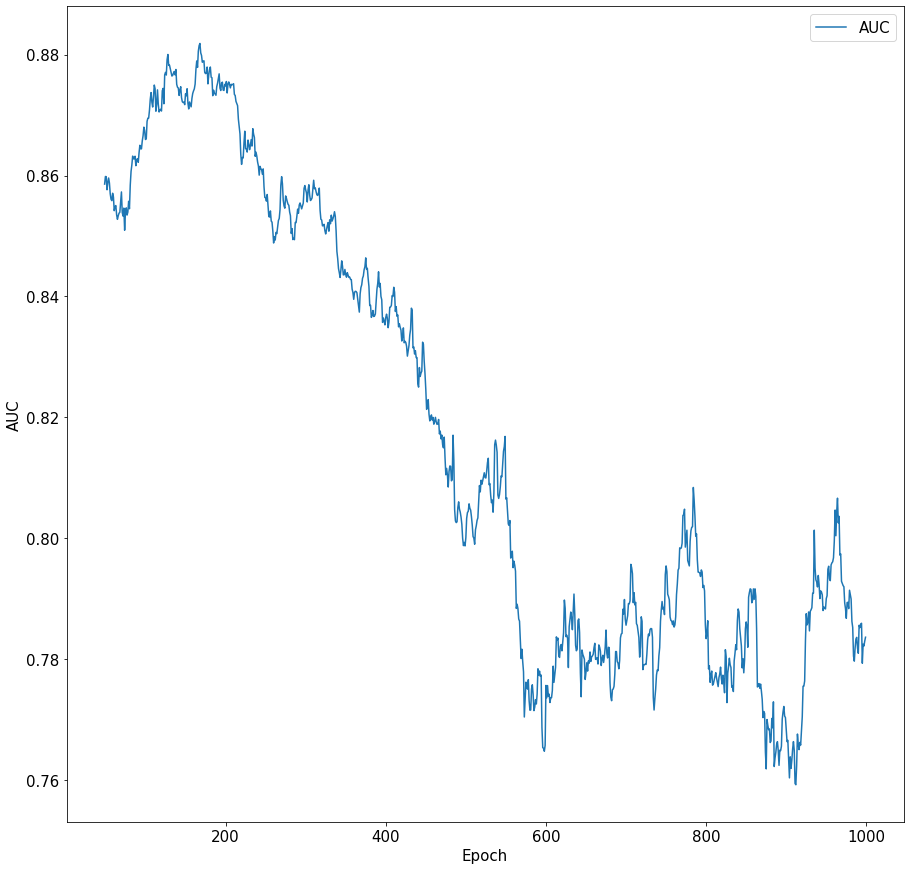

In [44]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 15))

plt.plot(
    range(len(val_auc_list)),
    ma,
    label="AUC"
)
plt.xlabel("Epoch", fontsize=font_size)
plt.ylabel("AUC", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.legend(fontsize=font_size)

plt.show()